# Wiggle

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
# Prepare BAM files
WD = os.path.expanduser('~/data/2023_wiggle')

def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

/tmp/ipykernel_2950809/386494431.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    # df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/7 [00:00<?, ?it/s]

SPAN 0


file modification     cell  \
104  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3     HMEC   
242  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K27me3    HepG2   
162  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3  GM12878   
79   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3     K562   
157  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3     NHLF   

    replicate   peaks         tool dataset  
104      rep2  133755  MACS2 broad  ENCODE  
242      rep1   34852        SICER  ENCODE  
162      rep2    4867  MACS2 broad  ENCODE  
79       rep1   67417        MACS2  ENCODE  
157      rep1     513  MACS2 broad  ENCODE

In [8]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/4 [00:00<?, ?it/s]

SPAN 0


file modification      cell  \
69   /home/jetbrains/data/2023_Immune/macs2/CD4_H3K...      H3K4me3       CD4   
75   /home/jetbrains/data/2023_Immune/macs2/Monocyt...      H3K27ac  Monocyte   
24   /home/jetbrains/data/2023_Immune/macs2/CD4_H3K...      H3K27ac       CD4   
15   /home/jetbrains/data/2023_Immune/macs2/PBMC_H3...      H3K4me3      PBMC   
136  /home/jetbrains/data/2023_Immune/sicer/NK_H3K4...      H3K4me1        NK   

    replicate  peaks         tool  dataset  
69             28589  MACS2 broad  Roadmap  
75             45525  MACS2 broad  Roadmap  
24             61162        MACS2  Roadmap  
15             25166        MACS2  Roadmap  
136            20053        SICER  Roadmap

In [9]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

In [10]:
# Remove outliers, see 2023 figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', '')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

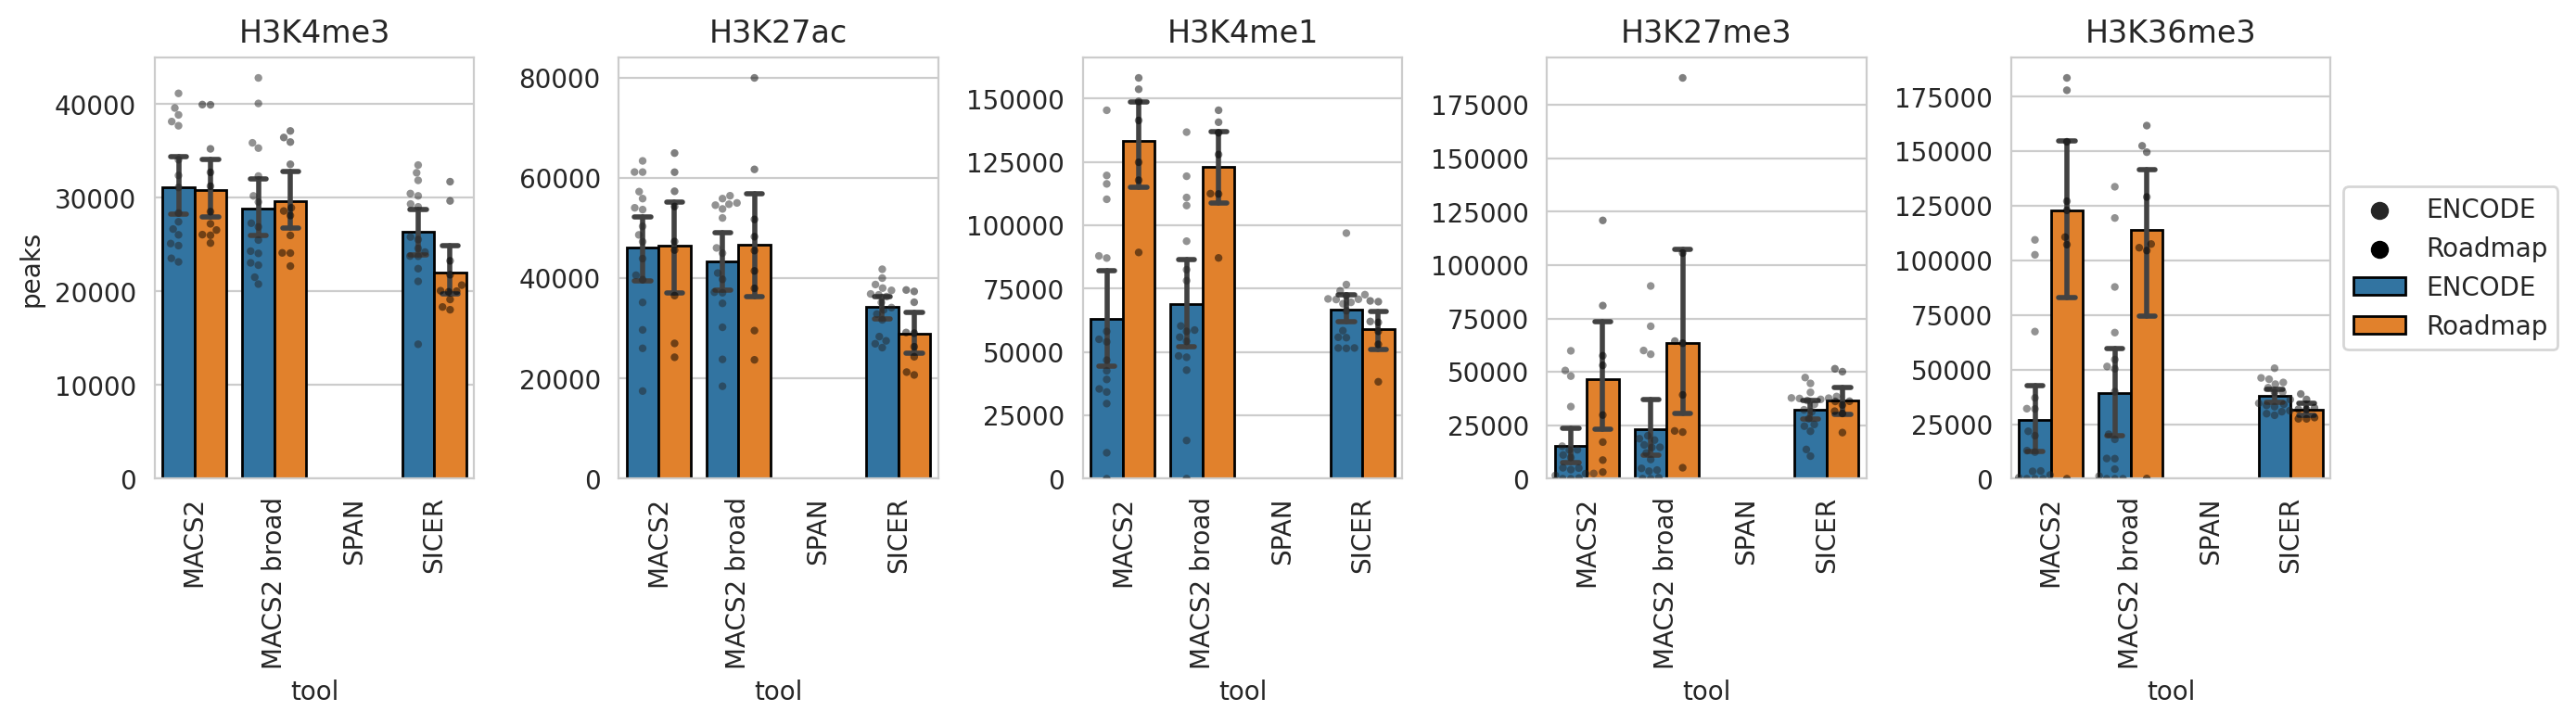

In [11]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, color="black", alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Inspect BAMs

In [12]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [13]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams

  0%|          | 0/206 [00:00<?, ?it/s]

bam_file modification     cell  \
0    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     NHLF   
1    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3     NHEK   
2    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac     NHEK   
3    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K27me3     HSMM   
4    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1     K562   
..                                                 ...          ...      ...   
98   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control  GM12878   
99   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me3     NHEK   
100  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control       H1   
101  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      Control     HSMM   
102  /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me3       H1   

    replicate     reads dataset  
0        rep1  14385159  ENCODE  
1        rep2   7569713  ENCODE  
2        rep1   9377615  ENCODE  
3        rep2   8356060  ENCODE  
4        rep2   7777248  ENCODE  
..        ...       ...     ...  
98       rep1   5699825  ENCODE  
99       rep1   8169225  ENCODE  
100      rep2   2998695  ENCODE  
101      rep2   7218491  ENCODE  
102      rep1   5729862  ENCODE  

[103 rows x 6 columns]

In [14]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams

  0%|          | 0/112 [00:00<?, ?it/s]

bam_file modification      cell  \
0   /home/jetbrains/data/2023_Immune/bams/CD4ABT_C...      Control    CD4ABT   
1   /home/jetbrains/data/2023_Immune/bams/CD4_Cont...      Control       CD4   
2   /home/jetbrains/data/2023_Immune/bams/TCell_Co...      Control     TCell   
3   /home/jetbrains/data/2023_Immune/bams/CD34_H3K...      H3K4me3      CD34   
4   /home/jetbrains/data/2023_Immune/bams/CD34_H3K...     H3K27me3      CD34   
5   /home/jetbrains/data/2023_Immune/bams/NK_H3K4m...      H3K4me1        NK   
6   /home/jetbrains/data/2023_Immune/bams/CD4_H3K4...      H3K4me1       CD4   
7   /home/jetbrains/data/2023_Immune/bams/BCell_H3...      H3K27ac     BCell   
8   /home/jetbrains/data/2023_Immune/bams/CD34_H3K...     H3K27me3      CD34   
9   /home/jetbrains/data/2023_Immune/bams/CD4_H3K2...      H3K27ac       CD4   
10  /home/jetbrains/data/2023_Immune/bams/NK_H3K27...     H3K27me3        NK   
11  /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K4me3     TCell   
12  /home/jetbrains/data/2023_Immune/bams/CD34_H3K...      H3K4me1      CD34   
13  /home/jetbrains/data/2023_Immune/bams/CD34_H3K...      H3K27ac      CD34   
14  /home/jetbrains/data/2023_Immune/bams/CD4_H3K2...     H3K27me3       CD4   
15  /home/jetbrains/data/2023_Immune/bams/BCell_H3...      H3K4me1     BCell   
16  /home/jetbrains/data/2023_Immune/bams/CD4ABT_H...      H3K4me3    CD4ABT   
17  /home/jetbrains/data/2023_Immune/bams/CD34_Con...      Control      CD34   
18  /home/jetbrains/data/2023_Immune/bams/TCellBB_...      H3K4me3   TCellBB   
19  /home/jetbrains/data/2023_Immune/bams/TCellBB_...      H3K4me3   TCellBB   
20  /home/jetbrains/data/2023_Immune/bams/NK_H3K4m...      H3K4me3        NK   
21  /home/jetbrains/data/2023_Immune/bams/BCell_H3...     H3K36me3     BCell   
22  /home/jetbrains/data/2023_Immune/bams/CD34_H3K...     H3K36me3      CD34   
23  /home/jetbrains/data/2023_Immune/bams/NK_Contr...      Control        NK   
24  /home/jetbrains/data/2023_Immune/bams/CD4_H3K4...      H3K4me3       CD4   
25  /home/jetbrains/data/2023_Immune/bams/CD34_H3K...      H3K4me3      CD34   
26  /home/jetbrains/data/2023_Immune/bams/NK_H3K27...      H3K27ac        NK   
27  /home/jetbrains/data/2023_Immune/bams/Monocyte...     H3K27me3  Monocyte   
28  /home/jetbrains/data/2023_Immune/bams/BCell_Co...      Control     BCell   
29  /home/jetbrains/data/2023_Immune/bams/TCellBB_...      Control   TCellBB   
30  /home/jetbrains/data/2023_Immune/bams/CD4_H3K3...     H3K36me3       CD4   
31  /home/jetbrains/data/2023_Immune/bams/Monocyte...      H3K4me3  Monocyte   
32  /home/jetbrains/data/2023_Immune/bams/CD4_H3K2...     H3K27me3       CD4   
33  /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K4me1     TCell   
34  /home/jetbrains/data/2023_Immune/bams/CD4ABT_C...      Control    CD4ABT   
35  /home/jetbrains/data/2023_Immune/bams/CD34_H3K...      H3K27ac      CD34   
36  /home/jetbrains/data/2023_Immune/bams/BCell_H3...     H3K27me3     BCell   
37  /home/jetbrains/data/2023_Immune/bams/PBMC_H3K...      H3K27ac      PBMC   
38  /home/jetbrains/data/2023_Immune/bams/PBMC_Con...      Control      PBMC   
39  /home/jetbrains/data/2023_Immune/bams/CD4_H3K3...     H3K36me3       CD4   
40  /home/jetbrains/data/2023_Immune/bams/PBMC_H3K...      H3K4me3      PBMC   
41  /home/jetbrains/data/2023_Immune/bams/TCell_H3...     H3K27me3     TCell   
42  /home/jetbrains/data/2023_Immune/bams/TCell_H3...     H3K36me3     TCell   
43  /home/jetbrains/data/2023_Immune/bams/PBMC_H3K...     H3K36me3      PBMC   
44  /home/jetbrains/data/2023_Immune/bams/TCell_H3...      H3K27ac     TCell   
45  /home/jetbrains/data/2023_Immune/bams/Monocyte...      Control  Monocyte   
46  /home/jetbrains/data/2023_Immune/bams/Monocyte...      H3K4me1  Monocyte   
47  /home/jetbrains/data/2023_Immune/bams/CD4ABT_H...      H3K4me3    CD4ABT   
48  /home/jetbrains/data/2023_Immune/bams/Monocyte...     H3K36me3  Monocyte   
49  /home/jetbrains/data/2023_Immune/bams/CD3

In [15]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


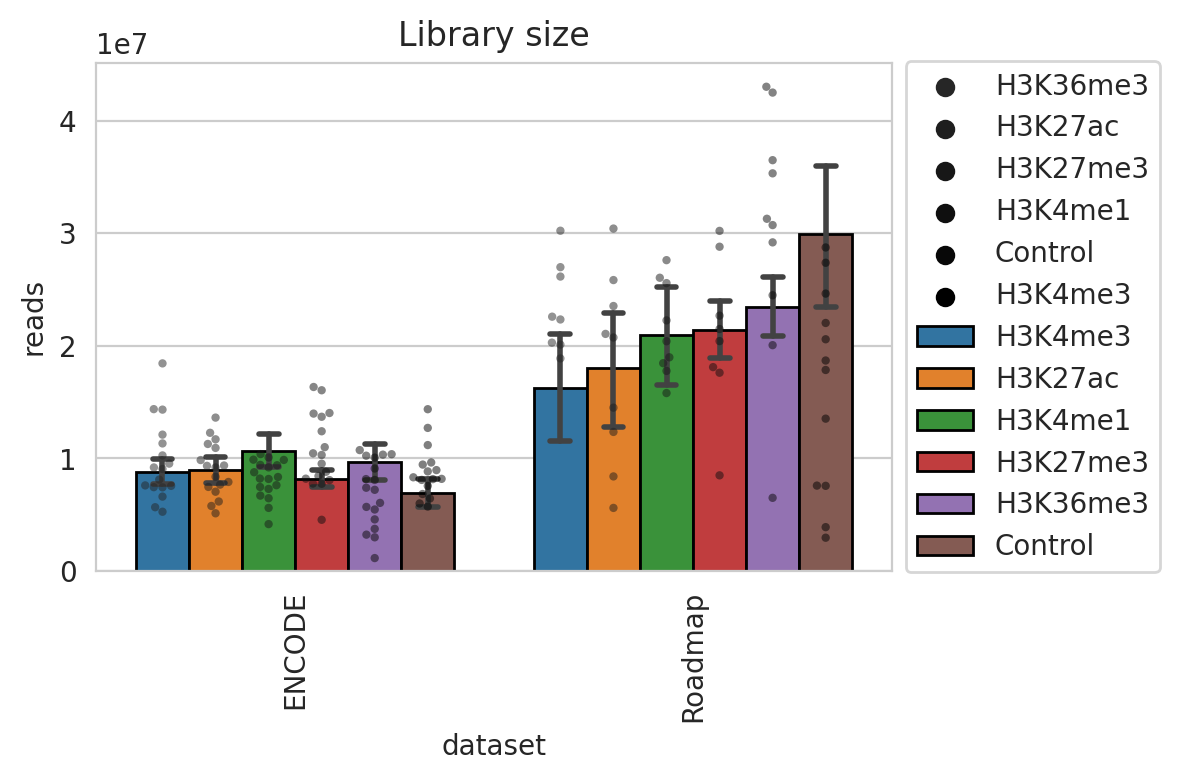

In [16]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            hue_order=MODIFICATIONS+['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, color="black", alpha=0.5,
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Wiggle

In [20]:
! mkdir -p {WD}/bed

# df_bam_beds = df_bams[(df_bams['modification'].isin(['H3K27ac', 'H3K4me1', 'Control'])) & 
#                       (df_bams['dataset'] == 'ENCODE')].copy()
df_bam_beds = df_bams[
    (df_bams['modification'] == 'H3K27me3') & (df_bams['cell'] == 'Monocyte') & (df_bams['replicate'] == '') |
    (df_bams['modification'] == 'H3K27ac') & (df_bams['cell'] == 'K562') & (df_bams['replicate'] == 'rep1') |
    (df_bams['modification'] == 'H3K4me3') & (df_bams['cell'] == 'CD4') & (df_bams['replicate'] == '') |
    (df_bams['modification'] == 'H3K4me1') & (df_bams['cell'] == 'H1') & (df_bams['replicate'] == 'rep1') |
    (df_bams['modification'] == 'H3K36me3') & (df_bams['cell'] == 'CD4') & (df_bams['replicate'] == '')
]
df_bam_beds

bam_file modification      cell  \
25   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1        H1   
58   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac      K562   
127  /home/jetbrains/data/2023_Immune/bams/CD4_H3K4...      H3K4me3       CD4   
130  /home/jetbrains/data/2023_Immune/bams/Monocyte...     H3K27me3  Monocyte   
133  /home/jetbrains/data/2023_Immune/bams/CD4_H3K3...     H3K36me3       CD4   

    replicate     reads  dataset  
25       rep1   8443445   ENCODE  
58       rep1  11704712   ENCODE  
127            27387086  Roadmap  
130            22268131  Roadmap  
133            30233360  Roadmap

In [21]:
beds = []
for _, (bam_file, m, c, r, _, _) in tqdm(list(df_bam_beds.iterrows())):
    bed_file = f'{WD}/bed/{os.path.basename(bam_file).replace(".bam", ".bed")}'
    print(bed_file)
    beds.append(bed_file)
    if not os.path.exists(bed_file):
        ! bamToBed -i {bam_file} > {bed_file}
df_bam_beds['bed_file'] = beds
df_bam_beds.sample(3)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/jetbrains/data/2023_wiggle/bed/GSM646341_H1_H3K4me1_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646434_K562_H3K27ac_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/CD4_H3K4me3_hg38_ENCFF728LMW.bed
/home/jetbrains/data/2023_wiggle/bed/Monocyte_H3K27me3_gh38_ENCFF850DZD.bed
/home/jetbrains/data/2023_wiggle/bed/CD4_H3K36me3_hg38_ENCFF489CFC.bed


/tmp/ipykernel_2950809/2587153835.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bam_beds['bed_file'] = beds


bam_file modification      cell  \
130  /home/jetbrains/data/2023_Immune/bams/Monocyte...     H3K27me3  Monocyte   
133  /home/jetbrains/data/2023_Immune/bams/CD4_H3K3...     H3K36me3       CD4   
58   /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac      K562   

    replicate     reads  dataset  \
130            22268131  Roadmap   
133            30233360  Roadmap   
58       rep1  11704712   ENCODE   

                                              bed_file  
130  /home/jetbrains/data/2023_wiggle/bed/Monocyte_...  
133  /home/jetbrains/data/2023_wiggle/bed/CD4_H3K36...  
58   /home/jetbrains/data/2023_wiggle/bed/GSM646434...

# Extreme wiggle

In [ ]:
! mkdir -p {WD}/bams

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

FRACTION_SIGNALS = [80, 20]
VARIATIONS = [1000, 10000]

for (f, v) in product(FRACTION_SIGNALS, VARIATIONS):
    print(f, v)
    for _, (bam_file, m, c, r, bed_file) in tqdm(
            df_bam_beds[['bam_file', 'modification', 'cell', 'replicate', 'bed_file']].iterrows()
    ):
        if m == 'Control':
            ! ln -sf {bam_file} {WD}/bams/{os.path.basename(bam_file)} 
            continue

        result_file = f'{WD}/bams/{m}_{c}_{r}_{f}_{v}.bam'
        print(result_file)
        if os.path.exists(result_file):
            continue
        t = pd.read_csv(bed_file, sep='\t', header=None)
        print('Reads', len(t))

        print(f'Wiggle var {v} Signal {f} wiggle {100 - f}')
        signal = t.sample(int(len(t) * f * 0.01))
        wiggle = t.sample(int(len(t) * (100 - f) * 0.01))
        delta = [int(x) for x in np.random.normal(0, v, size=len(wiggle))]
        wiggle[1] += delta
        wiggle[2] += delta
        # Ensure generated reads have proper coordinates
        wiggle.loc[wiggle[1] < 1, 1] = 1
        wiggle.loc[wiggle[2] < 1, 2] = 1
        t = pd.concat([signal, wiggle]).reset_index(drop=True)
        print('Wiggle coverage', len(t))
        del signal, wiggle, delta
        t.to_csv(tf, sep='\t', index=False, header=None)
        del t
        ! cat {tf} | sort -k1,1 -k2,2n -k3,3n > {tf2}
        ! rm {tf}
        ! bedToBam -i {tf2} -g {WD}/hg38.chrom.sizes > {result_file}
        ! rm {tf2}
        print('Done', result_file)

80 1000


0it [00:00, ?it/s]

/home/jetbrains/data/2023_wiggle/bams/H3K4me1_H1_rep1_80_1000.bam
Reads 8443445
Wiggle var 1000 Signal 80 wiggle 20
Wiggle coverage 8443445


## Create wiggle BAMs

In [54]:
def add_names(df):
    df['name'] = df['type']
    df.loc[df['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
    # df.loc[df['type'] == 'x1.001_N3', 'name'] = 'ENCODE Upscale 1.001N3'
    # df.loc[df['type'] == 'x1.01_N3', 'name'] = 'ENCODE Upscale 1.01N3'    
    # df.loc[df['type'] == 'x1.05_N10', 'name'] = 'ENCODE Upscale 1.05'
    # df.loc[df['type'] == 'x1.05_N3', 'name'] = 'ENCODE Upscale 1.05N3'
    # df.loc[df['type'] == 'x1.5_N10', 'name'] = 'ENCODE Upscale 1.5'
    # df.loc[df['type'] == 'x1.5_N3', 'name'] = 'ENCODE Upscale 1.5N3'
    df.loc[df['type'] == 'x2_N10', 'name'] = 'ENCODE Upscale'
    # df.loc[df['type'] == 'x2_N3', 'name'] = 'ENCODE Upscale N3'
    df.loc[df['type'] == 'w80_20_N2000', 'name'] = 'ENCODE Wiggle'
    df.loc[df['type'] == 'x2_N10_w80_20_N2000', 'name'] = 'ENCODE Upscale + Wiggle'

In [0]:
! mkdir -p {WD}/bams

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

UPSCALE_X = 2
FRACTION_SIGNAL = 80
FRACTION_WIGGLE = 100 - FRACTION_SIGNAL

for var_upscale, var_wiggle in tqdm(product([0, 10], [0, 2000])):
    if var_upscale == 0 and var_wiggle == 0:
        continue
    var_name = '' if var_upscale == 0 else f'x{UPSCALE_X}_N{var_upscale}'
    if var_wiggle != 0:
        if var_name != '':
            var_name += '_'
        var_name += f'w{int(FRACTION_SIGNAL)}_{int(FRACTION_WIGGLE)}_N{var_wiggle}'
    print('upscale', var_upscale, 'wiggle', var_wiggle, 'name', var_name)

    wiggles = []
    for _, (bam_file, m, c, r, bed_file) in tqdm(
            df_bam_beds[['bam_file', 'modification', 'cell', 'replicate', 'bed_file']].iterrows()
    ):
        print(var_name, m, c, r, bed_file)
        if m == 'Control':
            wiggles.append(None)
            ! ln -sf {bam_file} {WD}/bams/{os.path.basename(bam_file)} 
            continue
        
        result_file = f'{WD}/bams/{m}_{c}_{r}_{var_name}.bam'
        wiggles.append(result_file)
        print(result_file)
        if os.path.exists(result_file):
            continue
        t = pd.read_csv(bed_file, sep='\t', header=None)
        print('Reads', len(t))
    
        if var_upscale != 0:
            print(f'Upscale coverage var {var_upscale} x {UPSCALE_X}')
            if UPSCALE_X == 2:
                extra = t.copy()  # Double
            elif UPSCALE_X < 2:
                extra = t.sample(int(len(t) * (UPSCALE_X - 1.0))).copy()  # +X% coverage
            else:
                raise Exception(f'Illegal x {UPSCALE_X}')
            delta_small = [int(x) for x in np.random.normal(0, var_upscale, size=len(extra))]
            extra[1] += delta_small
            extra[2] += delta_small
            del delta_small
            # Ensure generated reads have proper coordinates
            extra.loc[extra[1] < 1, 1] = 1
            extra.loc[extra[2] < 1, 2] = 1
            t = pd.concat([t, extra]).reset_index(drop=True) 
            print('Upscaled coverage', len(t))
            t.to_csv(tf, sep='\t', index=False, header=None)
        
        if var_wiggle != 0:
            print(f'Wiggle var {var_wiggle} Signal {FRACTION_SIGNAL} wiggle {FRACTION_WIGGLE}')
            signal = t.sample(int(len(t) * FRACTION_SIGNAL * 0.01))
            wiggle = t.sample(int(len(t) * FRACTION_WIGGLE * 0.01))
            delta = [int(x) for x in np.random.normal(0, var_wiggle, size=len(wiggle))]
            wiggle[1] += delta
            wiggle[2] += delta
            # Ensure generated reads have proper coordinates
            wiggle.loc[wiggle[1] < 1, 1] = 1
            wiggle.loc[wiggle[2] < 1, 2] = 1
            t = pd.concat([signal, wiggle]).reset_index(drop=True)
            print('Wiggle coverage', len(t))
            del signal, wiggle, delta
            t.to_csv(tf, sep='\t', index=False, header=None)
            
        del t
        ! cat {tf} | sort -k1,1 -k2,2n -k3,3n > {tf2}
        ! rm {tf}
        ! bedToBam -i {tf2} -g {WD}/hg38.chrom.sizes > {result_file}
        ! rm {tf2}
        print('Done', result_file)
    df_bam_beds[var_name] = wiggles
df_bam_beds.sample(3)

## Analyze generated BAMs

In [81]:
df_wiggle_bams = load_bams(WD + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
df_wiggle_bams.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

bam_file modification     cell  \
43  /home/jetbrains/data/2023_wiggle/bams/H3K4me1_...      H3K4me1     HMEC   
89  /home/jetbrains/data/2023_wiggle/bams/H3K4me1_...      H3K4me1     NHLF   
13  /home/jetbrains/data/2023_wiggle/bams/H3K27ac_...      H3K27ac  GM12878   

   replicate     reads  
43      rep2  27978287  
89      rep2  14040462  
13      rep1  14098116

In [82]:
df_wiggle_bams['type'] = [re.sub('.*rep[12]_|_q.*|-W.*|_broad.*|_200_0.05.*|\\.bam', '', os.path.basename(f)) for f in df_wiggle_bams['bam_file']]
df_wiggle_bams.sample(3)

bam_file modification   cell  \
12  /home/jetbrains/data/2023_wiggle/bams/H3K4me1_...      H3K4me1   HSMM   
24  /home/jetbrains/data/2023_wiggle/bams/H3K27ac_...      H3K27ac  HepG2   
92  /home/jetbrains/data/2023_wiggle/bams/H3K4me1_...      H3K4me1   NHLF   

   replicate     reads                 type  
12      rep2  16416792               x2_N10  
24      rep1  14948051  x2_N10_w80_20_N2000  
92      rep2  28080926               x2_N10

In [83]:
df_immune_downsampled_bams = load_bams(IMMUNE_PATH + '_10M/bams', ['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, IMMUNE_REPS, None)
df_immune_downsampled_bams['type'] = 'Roadmap_10M'
df_immune_downsampled_bams.sample(3)

  0%|          | 0/112 [00:00<?, ?it/s]

bam_file modification   cell  \
9   /home/jetbrains/data/2023_Immune_10M/bams/CD34...      H3K4me1   CD34   
16  /home/jetbrains/data/2023_Immune_10M/bams/PBMC...      H3K27ac   PBMC   
11  /home/jetbrains/data/2023_Immune_10M/bams/TCel...      H3K4me1  TCell   

   replicate     reads         type  
9             10002797  Roadmap_10M  
16            10004954  Roadmap_10M  
11             9998683  Roadmap_10M

In [93]:
t = df_encode_bams[df_encode_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t['type'] = 'ENCODE'

t2 = df_immune_bams[df_immune_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t2['type'] = 'Roadmap'

t = pd.concat([t, t2, df_immune_downsampled_bams, df_wiggle_bams]).reset_index(drop=True)
add_names(t)

H3K27ac
H3K4me1


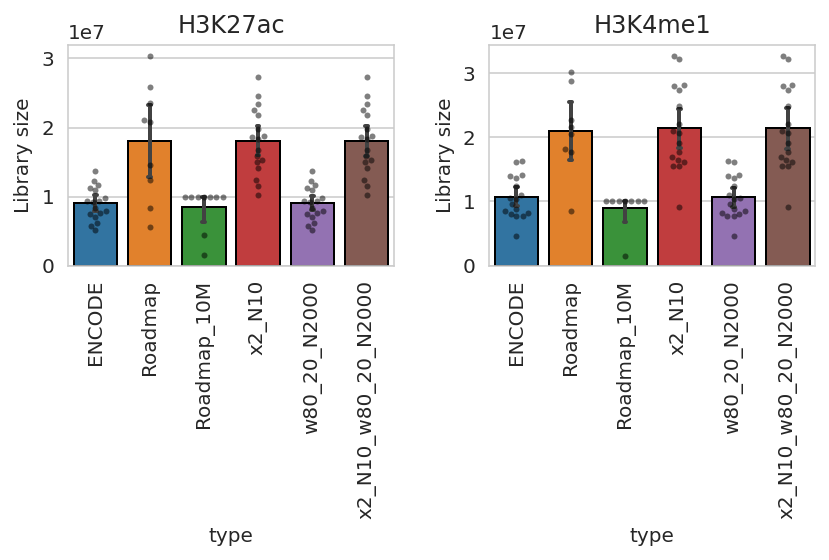

In [94]:
plt.figure(figsize=(6, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]

    sns.barplot(data=t[t['modification'] == m], x='type', y='reads', 
                order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'w80_20_N2000', 'x2_N10_w80_20_N2000'],
                capsize=.05, errwidth=2, edgecolor="black",
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='type', y='reads',
                  dodge=True, size=3, color="black", alpha=0.5,
                  order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'w80_20_N2000', 'x2_N10_w80_20_N2000'],
                  ax=ax)
    ax.set_title(m)
    ax.set_ylabel('Library size')
    # Put a legend to the right of the current axis
    # g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=200 span_gap=0 --rerun-trigger mtime; 

```

## BigWigs

In [262]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [263]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
encode_bws['dataset'] = 'ENCODE'
display(encode_bws.sample(3))

immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, None)
immune_bws['dataset'] = 'Roadmap'
display(immune_bws.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

file modification   cell  \
84  /home/jetbrains/data/2023_GSE26320/bw/GSM64643...     H3K36me3   K562   
12  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...     H3K36me3  HepG2   
51  /home/jetbrains/data/2023_GSE26320/bw/GSM64634...      H3K4me1     H1   

   replicate dataset  
84      rep2  ENCODE  
12      rep1  ENCODE  
51      rep1  ENCODE

  0%|          | 0/56 [00:00<?, ?it/s]

file modification      cell  \
19  /home/jetbrains/data/2023_Immune/bw/Monocyte_H...     H3K36me3  Monocyte   
27  /home/jetbrains/data/2023_Immune/bw/NK_H3K4me3...      H3K4me3        NK   
39  /home/jetbrains/data/2023_Immune/bw/CD34_H3K36...     H3K36me3      CD34   

   replicate  dataset  
19            Roadmap  
27            Roadmap  
39            Roadmap

In [264]:
immune_10m_bws = load_bws(IMMUNE_PATH + '_10M/bw', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, None)
immune_10m_bws['dataset'] = 'Roadmap_10M'
display(immune_10m_bws.sample(3))

  0%|          | 0/56 [00:00<?, ?it/s]

file modification   cell  \
9   /home/jetbrains/data/2023_Immune_10M/bw/CD4_H3...     H3K27me3    CD4   
13  /home/jetbrains/data/2023_Immune_10M/bw/PBMC_H...     H3K36me3   PBMC   
18  /home/jetbrains/data/2023_Immune_10M/bw/BCell_...      H3K4me1  BCell   

   replicate      dataset  
9             Roadmap_10M  
13            Roadmap_10M  
18            Roadmap_10M

In [265]:
wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
CELLS = list(wiggle_bws['cell'].unique())
wiggle_bws['type'] = [re.sub('.*rep[12]_|\\.bw', '', os.path.basename(f)) for f in wiggle_bws['file']]
wiggle_bws['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_bws['type']]
wiggle_bws['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_bws['type']]
display(wiggle_bws['type'].unique())
wiggle_bws.sample(5)

  0%|          | 0/120 [00:00<?, ?it/s]

array(['x2_N10', 'x2_N10_w80_20_N2000', 'w80_20_N2000'], dtype=object)

file modification     cell  \
26  /home/jetbrains/data/2023_wiggle/bw/H3K4me1_H1...      H3K4me1       H1   
19  /home/jetbrains/data/2023_wiggle/bw/H3K4me1_HS...      H3K4me1     HSMM   
40  /home/jetbrains/data/2023_wiggle/bw/H3K27ac_NH...      H3K27ac     NHEK   
32  /home/jetbrains/data/2023_wiggle/bw/H3K4me1_GM...      H3K4me1  GM12878   
16  /home/jetbrains/data/2023_wiggle/bw/H3K4me1_GM...      H3K4me1  GM12878   

   replicate                 type  upscale  wiggle  
26      rep2  x2_N10_w80_20_N2000      2.0  2000.0  
19      rep2               x2_N10      2.0     NaN  
40      rep2         w80_20_N2000      NaN  2000.0  
32      rep1  x2_N10_w80_20_N2000      2.0  2000.0  
16      rep2  x2_N10_w80_20_N2000      2.0  2000.0

In [266]:
t = wiggle_bws.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = encode_bws[(encode_bws['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
                (encode_bws['cell'].isin(CELLS)) 
].copy()
t2['scale'] = 0.5
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'

t3 = immune_bws[immune_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t3['scale'] = 2.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap'

t4 = immune_10m_bws[immune_10m_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t4['scale'] = 2.2
t4['wiggle'] = 0.0
t4['type'] = 'Roadmap_10M'

all_bws = pd.concat([t, t2, t3, t4]).reset_index(drop=True)
all_bws = all_bws.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in all_bws[['modification', 'cell', 'replicate']].iterrows()]].copy()
display(all_bws['type'].unique())
add_names(all_bws)
all_bws.sample(5)

array(['x2_N10', 'x2_N10_w80_20_N2000', 'w80_20_N2000', 'ENCODE',
       'Roadmap', 'Roadmap_10M'], dtype=object)

file modification   cell  \
0    /home/jetbrains/data/2023_wiggle/bw/H3K4me1_HS...      H3K4me1   HSMM   
148  /home/jetbrains/data/2023_Immune/bw/CD4_H3K4me...      H3K4me1    CD4   
96   /home/jetbrains/data/2023_wiggle/bw/H3K27ac_HS...      H3K27ac   HSMM   
90   /home/jetbrains/data/2023_wiggle/bw/H3K4me1_He...      H3K4me1  HepG2   
116  /home/jetbrains/data/2023_GSE26320/bw/GSM64640...      H3K4me1   HSMM   

    replicate          type  upscale  wiggle  scale  dataset            name  
0        rep1        x2_N10      2.0     0.0    2.0      NaN  ENCODE Upscale  
148                 Roadmap      NaN     0.0    2.5  Roadmap         Roadmap  
96       rep1  w80_20_N2000      1.0  2000.0    1.0      NaN   ENCODE Wiggle  
90       rep1  w80_20_N2000      1.0  2000.0    1.0      NaN   ENCODE Wiggle  
116      rep2        ENCODE      NaN     0.0    0.5   ENCODE          ENCODE

In [267]:
import pyBigWig

total_coverages = {}
ts = []
for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    # if ty not in ['ENCODE', 'Roadmap', 'x2_N10_w80_20_N2000']:  # Ignore others
    #     continue
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr)
            print('Total coverage', total_coverage)
            # Multiplier to align BAM coverage with BigWig estimation
            total_coverage *= 1.1e-2
            total_coverages[(m, c, r, ty)] = total_coverage
    except Exception:
        pass
        # print('ERROR')

total_coverages_df = pd.DataFrame([(m, c, r, ty, n) for (m, c, r, ty), n in total_coverages.items()],
                                  columns=['modification', 'cell', 'replicate', 'type', 'reads'])
add_names(total_coverages_df)
total_coverages_df.sample(5)

  0%|          | 0/168 [00:00<?, ?it/s]

H3K4me1 HSMM rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HSMM_rep1_x2_N10.bw
Total coverage 1279076438.0
H3K27ac NHLF rep2 x2_N10_w80_20_N2000
/home/jetbrains/data/2023_wiggle/bw/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bw
Total coverage 1204088800.0
H3K4me1 HSMM rep1 w80_20_N2000
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HSMM_rep1_w80_20_N2000.bw
Total coverage 664805569.0
H3K4me1 HepG2 rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HepG2_rep1_x2_N10.bw
Total coverage 2064067688.0
H3K4me1 HMEC rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HMEC_rep1_x2_N10.bw
Total coverage 2549946302.0
H3K4me1 HMEC rep1 x2_N10_w80_20_N2000
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HMEC_rep1_x2_N10_w80_20_N2000.bw
Total coverage 2620385640.0
H3K4me1 H1 rep2 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_H1_rep2_x2_N10.bw
Total coverage 2521720571.0
H3K4me1 NHLF rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_NHLF_rep1_x2_N10.bw
Total coverage 722061900.0
H3K4

modification   cell replicate         type         reads  \
89       H3K4me1   NHLF      rep2       x2_N10  2.406153e+07   
140      H3K27ac  TCell                Roadmap  2.841806e+07   
106      H3K4me1   NHLF      rep1       ENCODE  4.065504e+06   
161      H3K27ac    CD4            Roadmap_10M  9.340458e+06   
121      H3K4me1     H1      rep2       ENCODE  1.412015e+07   

                  name  
89      ENCODE Upscale  
140            Roadmap  
106             ENCODE  
161  Roadmap Downscale  
121             ENCODE

H3K27ac
H3K4me1


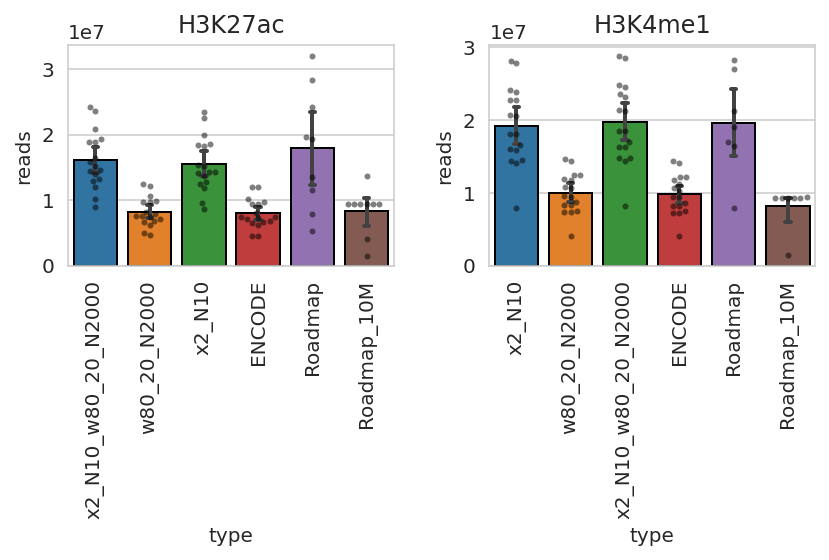

In [268]:
plt.figure(figsize=(6, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    sns.barplot(data=total_coverages_df[total_coverages_df['modification'] == m], x='type', y='reads', 
                # order=['ENCODE', 'Roadmap', 'Roadmap_10M',
                #        'x1.001_N3', 'x1.01_N3',
                #        'x1.05_N3', 'x1.05_N10', 'x1.2_N3', 'x1.2_N10', 'x1.5_N3', 'x1.5_N10', 'x2_N3', 'x2_N10',
                #        'w80_20_N2000', 'x2_N10_w80_20_N2000'],
                # order=['ENCODE', 'ENCODE Upscale 1.5', 'ENCODE Upscale 1.5N3',  'ENCODE Upscale', 'ENCODE Upscale N3', 'ENCODE Upscale + Wiggle', 'Roadmap', 'Roadmap Downscale'],
                capsize=.1, errwidth=2, edgecolor="black",
                ax=ax,)
    sns.swarmplot(data=total_coverages_df[total_coverages_df['modification'] == m], x='type', y='reads',
                  dodge=True, size=3, color="black", alpha=0.5,
                  ax=ax)
    ax.title.set_text(m)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Peaks number

In [238]:
wiggle_mix_peaks = load_peaks_path(WD, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)

  0%|          | 0/816 [00:00<?, ?it/s]

MACS2 102


  0%|          | 0/816 [00:00<?, ?it/s]

MACS2 broad 102


  0%|          | 0/102 [00:00<?, ?it/s]

SICER 102


  0%|          | 0/224 [00:00<?, ?it/s]

SPAN 102


In [239]:
wiggle_mix_peaks['type'] = [re.sub('.*rep[12]_|_q.*|-W.*|_broad.*|_200_0.05.*', '', os.path.basename(f)) for f in wiggle_mix_peaks['file']]
display(wiggle_mix_peaks['type'].unique())
wiggle_mix_peaks.sample(5)

array(['x2_N10', 'x2_N10_w80_20_N2000', 'w80_20_N2000'], dtype=object)

file modification   cell  \
314  /home/jetbrains/data/2023_wiggle/span/H3K27ac_...      H3K27ac   K562   
179  /home/jetbrains/data/2023_wiggle/macs2/H3K27ac...      H3K27ac   HSMM   
150  /home/jetbrains/data/2023_wiggle/macs2/H3K4me1...      H3K4me1   HMEC   
291  /home/jetbrains/data/2023_wiggle/sicer/H3K27ac...      H3K27ac   NHLF   
216  /home/jetbrains/data/2023_wiggle/sicer/H3K4me1...      H3K4me1  Huvec   

    replicate  peaks         tool                 type  
314      rep2  18101         SPAN         w80_20_N2000  
179      rep1  56038  MACS2 broad  x2_N10_w80_20_N2000  
150      rep1   6225  MACS2 broad         w80_20_N2000  
291      rep1  49113        SICER               x2_N10  
216      rep1  64391        SICER  x2_N10_w80_20_N2000

In [241]:
t = wiggle_mix_peaks.copy()
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
              (df_peaks['dataset'] == 'ENCODE') 
].copy()
t2['type'] = 'ENCODE'
wiggle_mix_original_peaks = pd.concat([t2, t]).reset_index(drop=True)
display(wiggle_mix_original_peaks['type'].unique())
add_names(wiggle_mix_original_peaks)
wiggle_mix_original_peaks.sample(5)

array(['ENCODE', 'x2_N10', 'x2_N10_w80_20_N2000', 'w80_20_N2000'],
      dtype=object)

file modification   cell  \
140  /home/jetbrains/data/2023_wiggle/macs2/H3K27ac...      H3K27ac  Huvec   
234  /home/jetbrains/data/2023_wiggle/macs2/H3K27ac...      H3K27ac   NHEK   
285  /home/jetbrains/data/2023_wiggle/macs2/H3K27ac...      H3K27ac   K562   
413  /home/jetbrains/data/2023_wiggle/sicer/H3K4me1...      H3K4me1   HMEC   
175  /home/jetbrains/data/2023_wiggle/macs2/H3K4me1...      H3K4me1   HMEC   

    replicate   peaks         tool dataset                 type  \
140      rep2   30459        MACS2     NaN  x2_N10_w80_20_N2000   
234      rep2   57581        MACS2     NaN         w80_20_N2000   
285      rep2   44422  MACS2 broad     NaN               x2_N10   
413      rep2   83434        SICER     NaN         w80_20_N2000   
175      rep2  122309        MACS2     NaN         w80_20_N2000   

                        name  
140  ENCODE Upscale + Wiggle  
234            ENCODE Wiggle  
285           ENCODE Upscale  
413            ENCODE Wiggle  
175            ENCODE Wiggle

H3K27ac NHEK rep1
H3K27ac HMEC rep1
H3K27ac GM12878 rep1
H3K27ac Huvec rep1
H3K27ac H1 rep1
H3K27ac HSMM rep1
H3K27ac NHLF rep1
H3K27ac K562 rep1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac HepG2 rep1
H3K27ac NHEK rep2
H3K27ac HMEC rep2
H3K27ac GM12878 rep2
H3K27ac Huvec rep2
H3K27ac H1 rep2
H3K27ac HSMM rep2
H3K27ac NHLF rep2
H3K27ac K562 rep2
H3K27ac HepG2 rep2
H3K4me1 NHEK rep1
H3K4me1 HMEC rep1
H3K4me1 GM12878 rep1
H3K4me1 Huvec rep1
H3K4me1 H1 rep1
H3K4me1 HSMM rep1
H3K4me1 NHLF rep1
H3K4me1 K562 rep1
H3K4me1 HepG2 rep1
H3K4me1 NHEK rep2
H3K4me1 HMEC rep2
H3K4me1 GM12878 rep2
H3K4me1 Huvec rep2
H3K4me1 H1 rep2
H3K4me1 HSMM rep2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 NHLF rep2
H3K4me1 K562 rep2
H3K4me1 HepG2 rep2


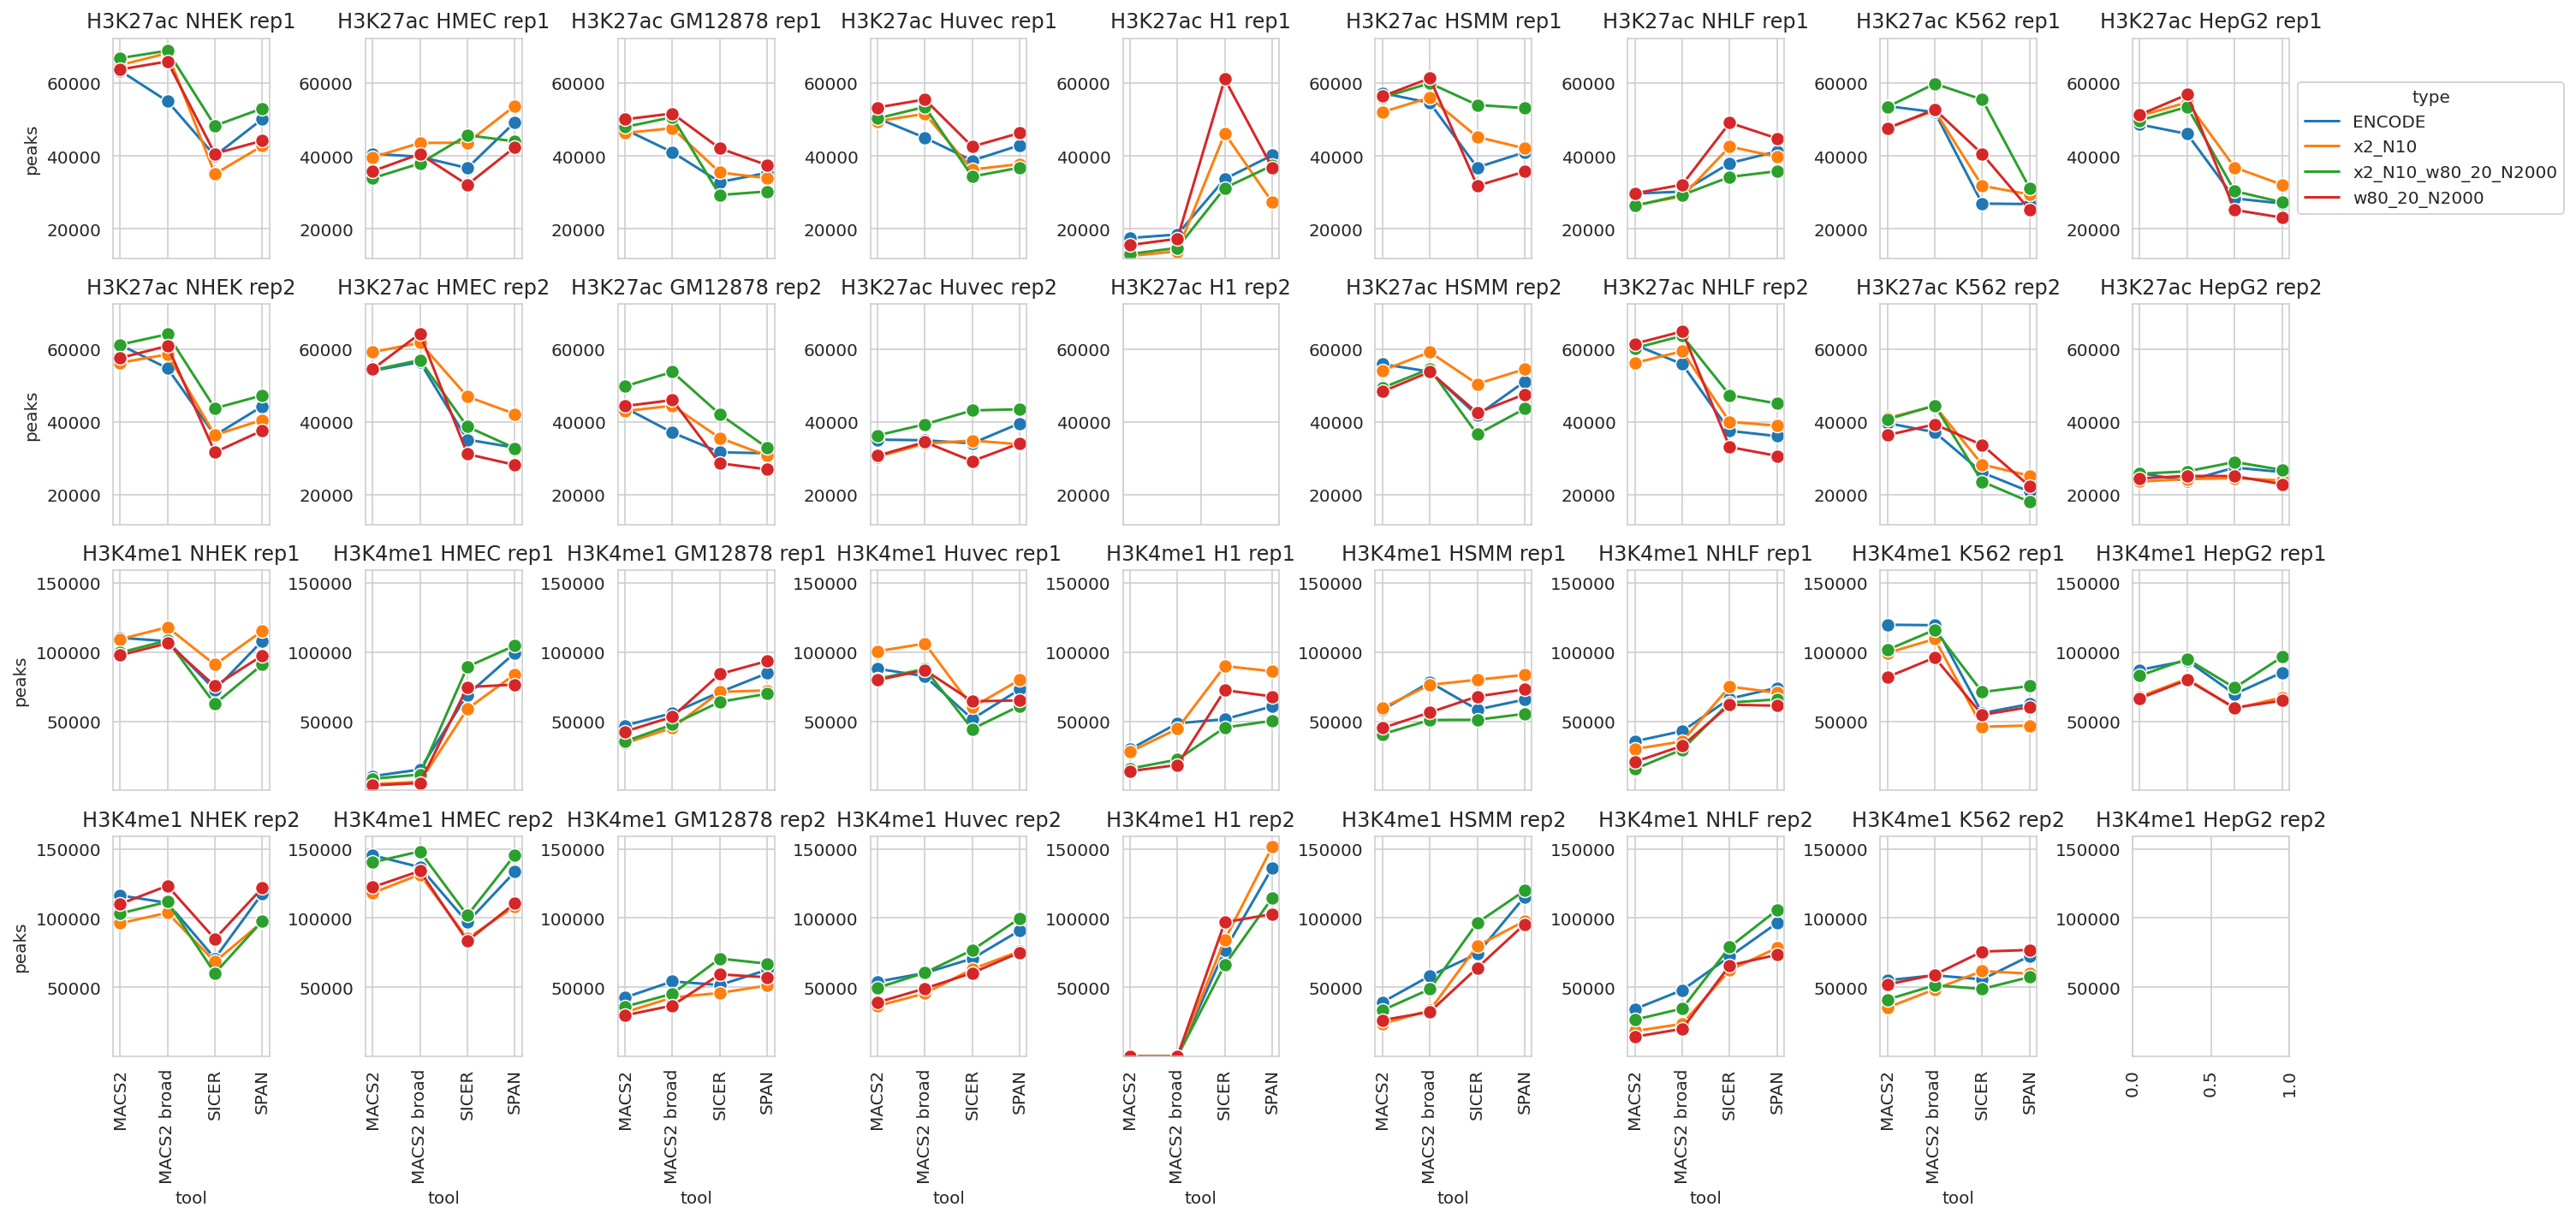

In [242]:
plt.figure(figsize=(21, 10))
CELLS = list(wiggle_mix_peaks['cell'].unique())
# CELLS = ['GM12878', 'K562', 'Huvec'] 
axs = [plt.subplot(4, len(CELLS), i + 1) for i in range(2 * len(CELLS) * 2)]

for i, (m, r, c) in enumerate(product(['H3K27ac', 'H3K4me1'], GSE26320_REPS, CELLS)):
    print(m, c, r)
    ax = axs[i]
    sns.lineplot(data=wiggle_mix_original_peaks[(wiggle_mix_original_peaks['modification']==m) &
                                                (wiggle_mix_original_peaks['cell'] == c) &
                                                (wiggle_mix_original_peaks['replicate'] == r)],
                 x='tool', y='peaks', hue='type',
                 # order=['ENCODE', 'Roadmap', 'Roadmap_10M', 'x2_N10', 'w80_20_N2000', 'x2_N10_w80_20_N2000'],
                 # errorbar='se', 
                 marker='o', markersize=8,
                 ax=ax)
    if i + 1 == len(CELLS):
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i % len(CELLS) != 0:
        ax.set_ylabel(None)
    if i < len(CELLS) * 3:
        # ax.set_xticks([], minor=False)
        ax.set_xticklabels([])   
        ax.set_xlabel(None)
    else:
        ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m} {c} {r}')
    ax.set_ylim(bottom = 0.95 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].min(),
                top = 1.05 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].max())
plt.tight_layout()
plt.show()

In [243]:
rows = []
for (m, c, r, t), group in wiggle_mix_original_peaks.groupby(['modification', 'cell', 'replicate', 'tool']):
    print(m, c, r, t, list(group['type'].unique()))
    original_peaks = group[group['type'] == 'ENCODE']['peaks'].values[0]
    for ty in ['x2_N10_w80_20_N2000', 'w80_20_N2000', 'x2_N10']:
        peaks = group[group['type'] == ty]['peaks'].values[0]
        rows.append((m, c, r, t, original_peaks, ty, peaks))
wiggle_compare_peaks = pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'tool', 'original_peaks',  'type', 'peaks'])
wiggle_compare_peaks['diff'] = wiggle_compare_peaks['peaks'] - wiggle_compare_peaks['original_peaks']
wiggle_compare_peaks['diff_abs'] = np.fabs(wiggle_compare_peaks['diff'])
wiggle_compare_peaks['diff_relative'] = [d(p - po, p + po) for p, po in zip(wiggle_compare_peaks['peaks'], wiggle_compare_peaks['original_peaks'])]
wiggle_compare_peaks['diff_relative_abs'] = np.fabs(wiggle_compare_peaks['diff_relative'])
wiggle_compare_peaks.sample(5)

H3K27ac GM12878 rep1 MACS2 ['ENCODE', 'x2_N10_w80_20_N2000', 'w80_20_N2000', 'x2_N10']
H3K27ac GM12878 rep1 MACS2 broad ['ENCODE', 'x2_N10_w80_20_N2000', 'x2_N10', 'w80_20_N2000']
H3K27ac GM12878 rep1 SICER ['ENCODE', 'w80_20_N2000', 'x2_N10_w80_20_N2000', 'x2_N10']
H3K27ac GM12878 rep1 SPAN ['ENCODE', 'x2_N10', 'w80_20_N2000', 'x2_N10_w80_20_N2000']
H3K27ac GM12878 rep2 MACS2 ['ENCODE', 'x2_N10_w80_20_N2000', 'x2_N10', 'w80_20_N2000']
H3K27ac GM12878 rep2 MACS2 broad ['ENCODE', 'x2_N10', 'x2_N10_w80_20_N2000', 'w80_20_N2000']
H3K27ac GM12878 rep2 SICER ['ENCODE', 'x2_N10_w80_20_N2000', 'w80_20_N2000', 'x2_N10']
H3K27ac GM12878 rep2 SPAN ['ENCODE', 'x2_N10', 'x2_N10_w80_20_N2000', 'w80_20_N2000']
H3K27ac H1 rep1 MACS2 ['ENCODE', 'x2_N10_w80_20_N2000', 'w80_20_N2000', 'x2_N10']
H3K27ac H1 rep1 MACS2 broad ['ENCODE', 'x2_N10_w80_20_N2000', 'x2_N10', 'w80_20_N2000']
H3K27ac H1 rep1 SICER ['ENCODE', 'x2_N10_w80_20_N2000', 'x2_N10', 'w80_20_N2000']
H3K27ac H1 rep1 SPAN ['ENCODE', 'x2_N10_w8

modification  cell replicate         tool  original_peaks  \
185      H3K27ac  NHLF      rep1  MACS2 broad           30217   
369      H3K4me1  NHEK      rep1         SPAN          108123   
274      H3K4me1  HMEC      rep2         SPAN          133431   
171      H3K27ac  NHEK      rep2  MACS2 broad           54766   
176      H3K27ac  NHEK      rep2        SICER           36343   

                    type   peaks   diff  diff_abs  diff_relative  \
185               x2_N10   32142   1925    1925.0       0.030870   
369  x2_N10_w80_20_N2000   97490 -10633   10633.0      -0.051714   
274         w80_20_N2000  110649 -22782   22782.0      -0.093338   
171  x2_N10_w80_20_N2000   58553   3787    3787.0       0.033419   
176               x2_N10   43760   7417    7417.0       0.092593   

     diff_relative_abs  
185           0.030870  
369           0.051714  
274           0.093338  
171           0.033419  
176           0.092593

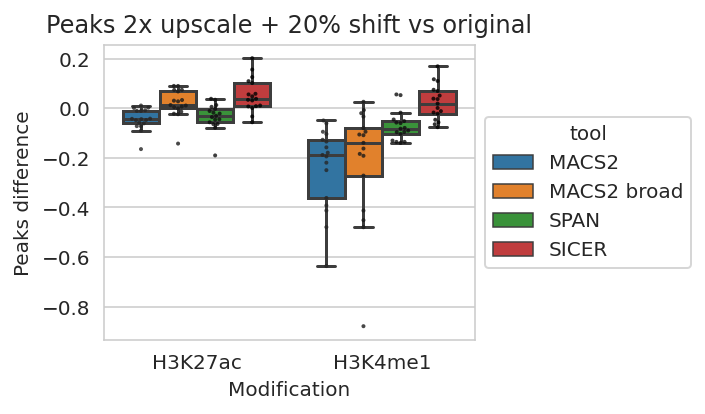

In [247]:
plt.figure(figsize=(5, 3))
ax = plt.axes()
t = wiggle_compare_peaks[wiggle_compare_peaks['type'] == 'x2_N10_w80_20_N2000']
sns.boxplot(data=t, x='modification', hue='tool', y='diff_relative',
            palette=TOOLS_PALETTE,
            order=['H3K27ac', 'H3K4me1'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='diff_relative',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=['H3K27ac', 'H3K4me1'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title(f'Peaks 2x upscale + 20% shift vs original')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Peaks lengths

In [257]:
print('Load lengths')
ts = []
for _, (file, m, c, r, ty, tool) in tqdm(
        wiggle_mix_original_peaks[['file', 'modification', 'cell', 'replicate', 'type', 'tool']].iterrows()
):
    # if c in ['H1', 'GM12878', 'HSMM', 'NHLF', 'HMEC']:
    #     continue
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
add_names(t)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length modification     cell replicate                 type  \
2141789     815      H3K27ac     NHEK      rep1               x2_N10   
2135987     250      H3K27ac  GM12878      rep2         w80_20_N2000   
4896392    6966      H3K27ac     NHLF      rep2  x2_N10_w80_20_N2000   
2765178     302      H3K27ac    Huvec      rep2               x2_N10   
4017548    1799      H3K4me1     NHLF      rep2  x2_N10_w80_20_N2000   
4047467    4399      H3K27ac     HSMM      rep1               x2_N10   
1870151    1144      H3K27ac     HMEC      rep2  x2_N10_w80_20_N2000   
2200329     383      H3K27ac    Huvec      rep2         w80_20_N2000   
791610      799      H3K27ac       H1      rep1               ENCODE   
2676577     635      H3K4me1     NHEK      rep1  x2_N10_w80_20_N2000   

                tool                     name  
2141789        MACS2           ENCODE Upscale  
2135987        MACS2            ENCODE Wiggle  
4896392         SPAN  ENCODE Upscale + Wiggle  
2765178  MACS2 broad           ENCODE Upscale  
4017548        SICER  ENCODE Upscale + Wiggle  
4047467        SICER           ENCODE Upscale  
1870151        MACS2  ENCODE Upscale + Wiggle  
2200329        MACS2            ENCODE Wiggle  
791610         SICER                   ENCODE  
2676577  MACS2 broad  ENCODE Upscale + Wiggle

H3K27ac MACS2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SPAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SICER
H3K4me1 MACS2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SPAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SICER


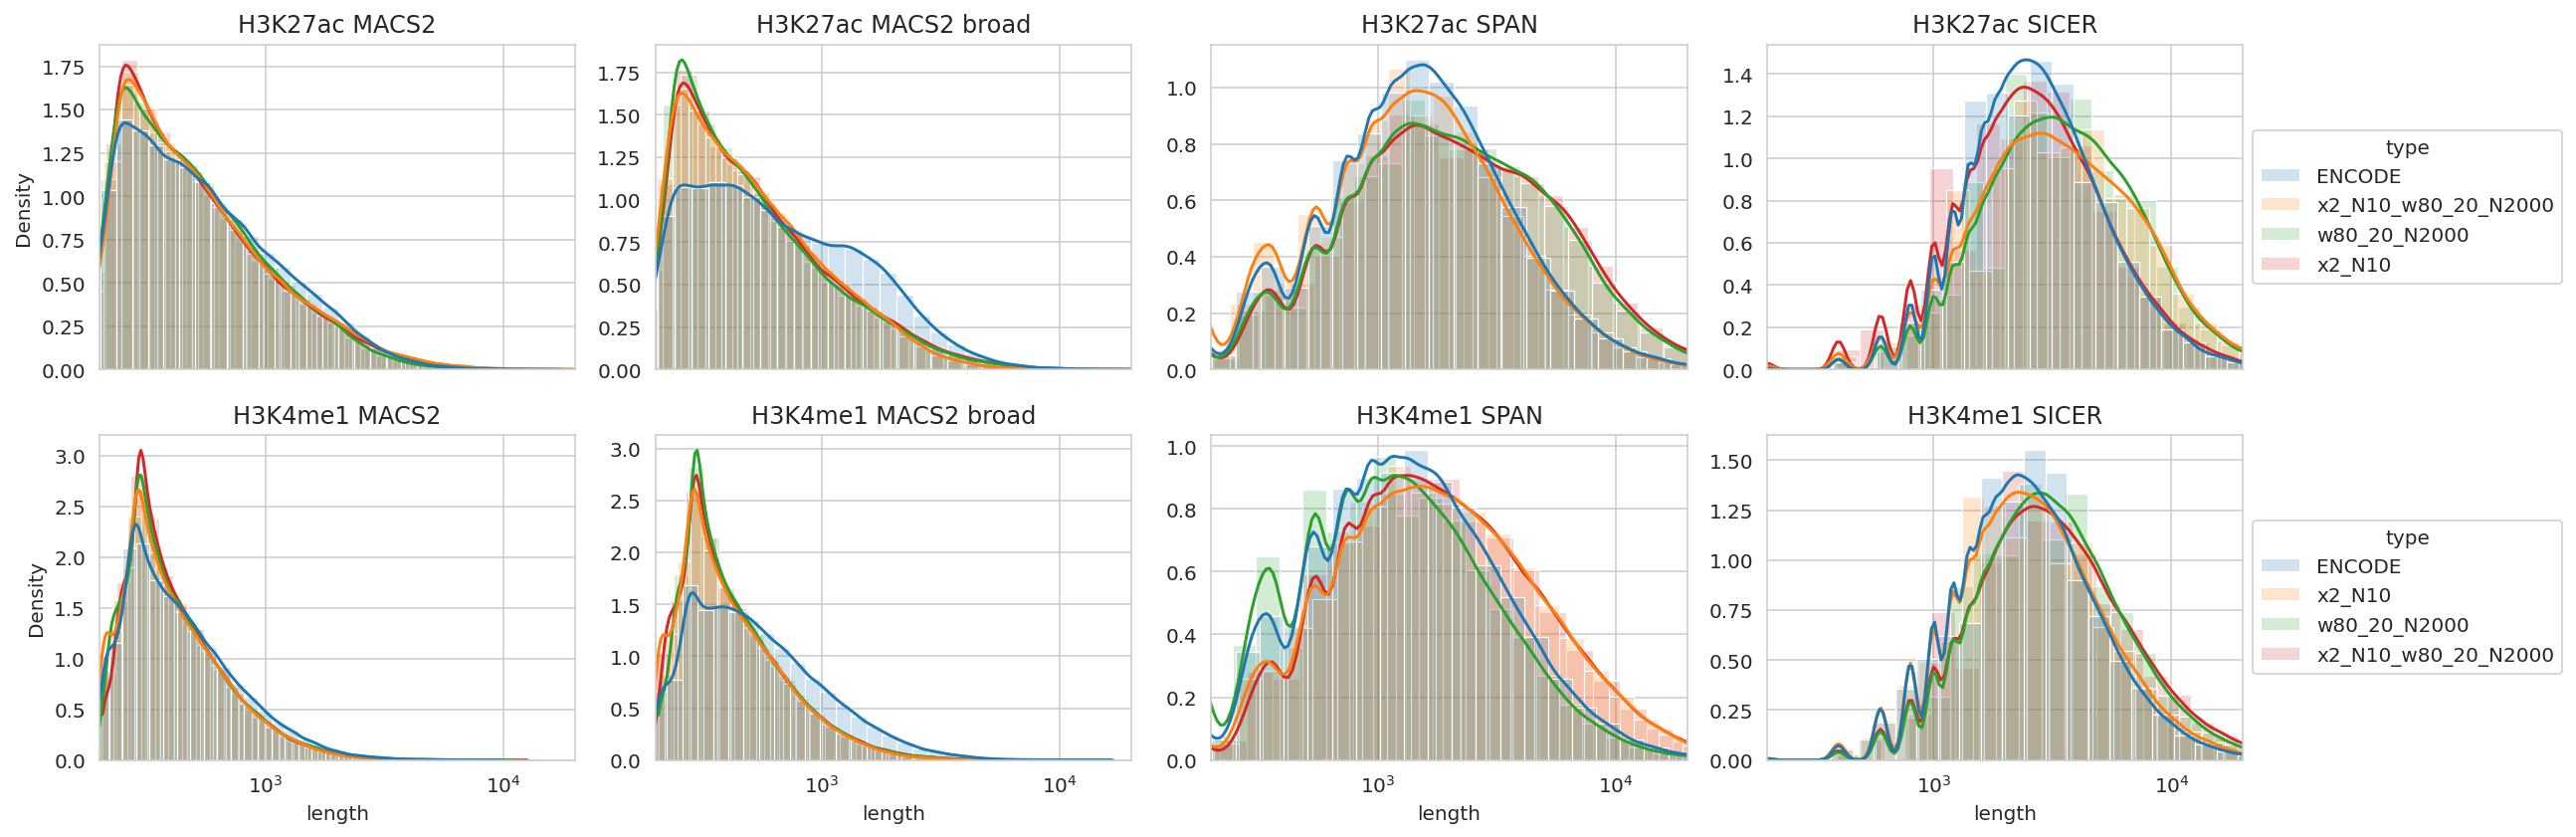

In [258]:
plt.figure(figsize=(18, 6))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, len(TOOLS), i + 1) for i in range(2 * len(TOOLS))]

for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification']==m) &
                                    (t['tool'].isin([tool]))],
                             x='length', hue='type',
                             # hue='type', hue_order=['ENCODE', 'Roadmap', 'Roadmap_10M',
                             #                        'x1.001_N3', 'x1.01_N3',
                             #                        'x1.05_N3', 'x1.05_N10', 'x1.2_N3', 'x1.2_N10', 'x1.5_N3', 'x1.5_N10', 'x2_N3', 'x2_N10',
                             #                        'w80_20_N2000', 'x2_N10_w80_20_N2000'],
                             # hue='name', hue_order=list(sorted(t['name'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2
                             )
    if (i + 1) % len(TOOLS) != 0:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if i % len(TOOLS) != 0:
        ax.set_ylabel(None)
    if i < len(TOOLS):
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {tool}')
    ax.set_xlim(2e2, 2e4)
plt.tight_layout()
plt.show()

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


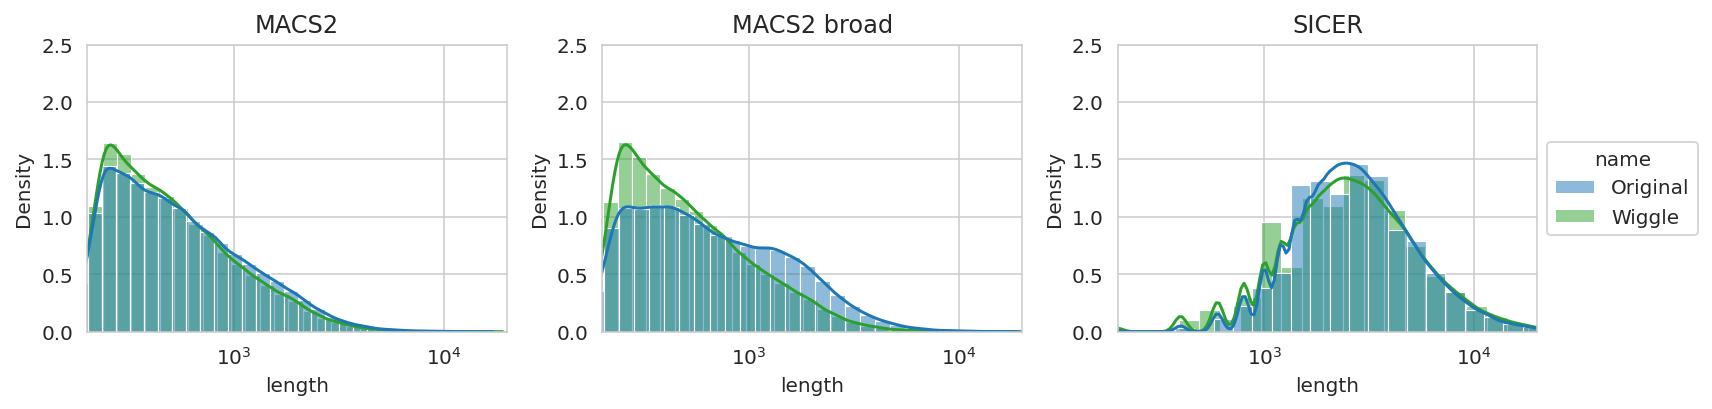

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


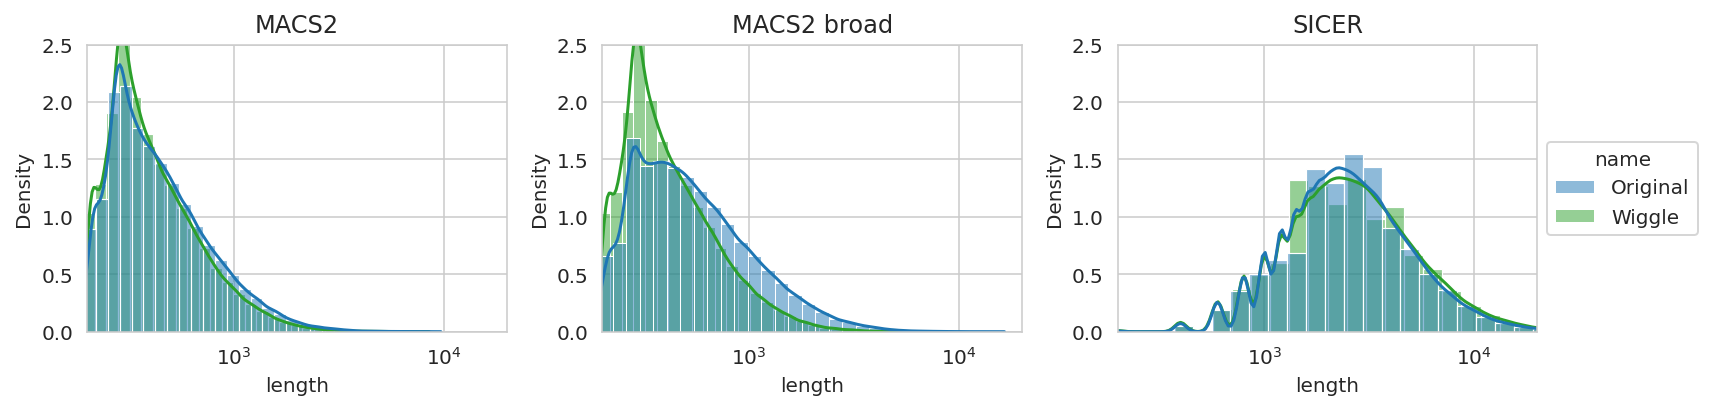

In [259]:
palette = plt.cm.get_cmap('tab10')
PALETTE = {'Original': palette(0), 'Wiggle': palette(2)}

tt = t[t['type'].isin(['ENCODE', 'x2_N10'])].copy()
tt.loc[tt['type'] == 'ENCODE', 'name'] = 'Original'
tt.loc[tt['type'] != 'ENCODE', 'name'] = 'Wiggle'
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=tt[(tt['modification'] == m) & (tt['tool'] == tool)],
                                 x='length', hue='name', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 hue_order=['Original', 'Wiggle'],
                                 palette=PALETTE
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


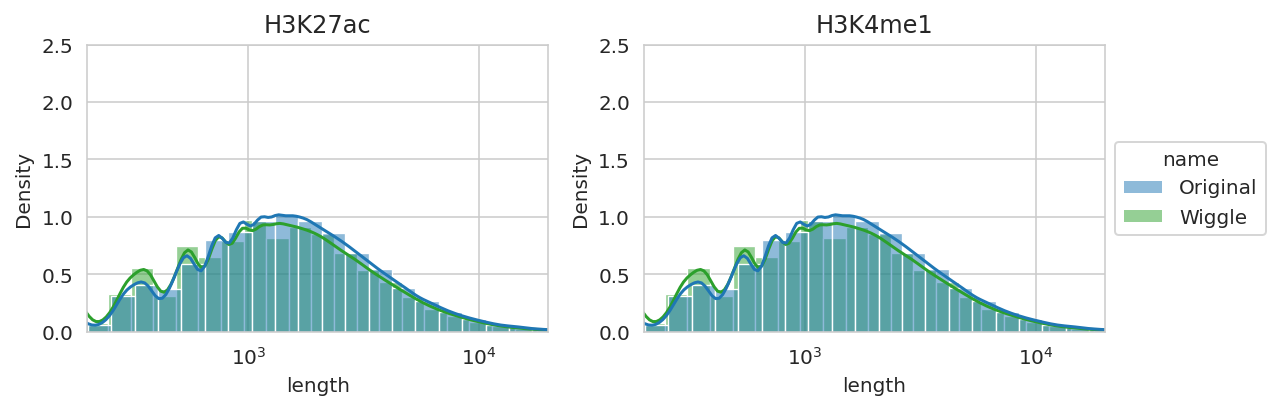

In [260]:
# tt = t[t['type'].isin(['ENCODE', 'x2_N10_w80_20_N2000'])].copy()
tt = t[t['type'].isin(['ENCODE', 'x2_N10'])].copy()
tt.loc[tt['type'] == 'ENCODE', 'name'] = 'Original'
tt.loc[tt['type'] != 'ENCODE', 'name'] = 'Wiggle'
plt.figure(figsize=(9, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=tt[tt['tool'] == 'SPAN'],
                             x='length', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             hue_order=['Original', 'Wiggle'],
                             palette=PALETTE
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{m}')
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [261]:
t2 = df_immune_peaks[(df_immune_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) &
                     (df_immune_peaks['replicate'] == '')].copy()
t2['type'] = 'Roadmap'

t3 = df_downsample[(df_downsample['reads'] == '10M') & 
                   (df_downsample['modification'].isin(['H3K27ac', 'H3K4me1']))].copy()
t3['type'] = 'Roadmap_10M'

wiggle_mix_original_all_peaks = pd.concat([t2, t3, wiggle_mix_original_peaks]).reset_index(drop=True)
display(wiggle_mix_original_all_peaks['type'].unique())
add_names(wiggle_mix_original_all_peaks)
wiggle_mix_original_all_peaks.sample(5)

array(['Roadmap', 'Roadmap_10M', 'ENCODE', 'x2_N10',
       'x2_N10_w80_20_N2000', 'w80_20_N2000'], dtype=object)

file modification   cell  \
141  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac   HMEC   
641  /home/jetbrains/data/2023_wiggle/span/H3K27ac_...      H3K27ac   K562   
495  /home/jetbrains/data/2023_wiggle/sicer/H3K27ac...      H3K27ac  Huvec   
25   /home/jetbrains/data/2023_Immune/macs2/TCell_H...      H3K4me1  TCell   
127  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac   K562   

    replicate   peaks         tool  dataset                 type reads  \
141      rep1   40609        MACS2   ENCODE               ENCODE   NaN   
641      rep2   25267         SPAN      NaN               x2_N10   NaN   
495      rep2   34924        SICER      NaN  x2_N10_w80_20_N2000   NaN   
25             145437  MACS2 broad  Roadmap              Roadmap   NaN   
127      rep1   53699        MACS2   ENCODE               ENCODE   NaN   

                        name  
141                   ENCODE  
641           ENCODE Upscale  
495  ENCODE Upscale + Wiggle  
25                   Roadmap  
127                   ENCODE

# Analyze BigWig regions by coverage 

In [269]:
def bw_peak_calling(bw_path, chrom_sizes, blacklist, bin, top_bins, merge=False):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / bin))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())
    # print(chromosomes)
    # print(chr_indx)

    print('Compute binned coverage')    
    binned_coverage = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            binned_coverage[istart: iend] =\
                np.array([x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=True, type='sum')])
    
    if blacklist is not None:
        print('Processing blacklisted regions')
        blacklist_marked = 0
        for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
            if chr not in chr_indx:
                continue
            offset = chr_indx[chr][0]
            for x in range(int(math.floor(start / bin)), int(math.ceil(end / bin)) + 1):
                binned_coverage[min(x - offset, len(binned_coverage) - 1)] = 0
                blacklist_marked += 1
        print(f'Marked {blacklist_marked} / {len(binned_coverage)} bins as blacklist')
    
    print('Total coverage', binned_coverage.sum())
    print('Split by chromosomes')
    if top_bins > len(binned_coverage):
        raise Exception(f'Too many top bins {top_bins} > {len(binned_coverage)}')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(binned_coverage, -top_bins)[-top_bins:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)
    # print(chr_xs)

    print('Collect final peaks')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        if merge:
            start = -1
            sum_coverage = 0
            for i, x in enumerate(xs):
                if i == 0:
                    start = x
                    sum_coverage = 0
                elif xs[i - 1] != x - 1:
                    peaks.append((chr, (start - offset) * bin, (xs[i - 1] + 1 - offset) * bin, sum_coverage))
                    start = x
                    sum_coverage = binned_coverage[x]
                else:
                    sum_coverage += binned_coverage[x]
            peaks.append((chr, (start - offset) * bin, (xs[-1] + 1 - offset) * bin, sum_coverage))
        else:
            for i, x in enumerate(xs):
                peaks.append((chr, (x - offset) * bin, (x + 1 - offset) * bin, binned_coverage[x])) 
    return pd.DataFrame(peaks, columns=['chromosome', 'start', 'end', 'coverage'])

## Black lists
https://github.com/Boyle-Lab/Blacklist/tree/master/lists

In [270]:
BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

chr     start       end                   3
0    chr10         0     45700     Low Mappability
1    chr10  38481300  38596500  High Signal Region
2    chr10  38782600  38967900  High Signal Region
3    chr10  39901300  41712900  High Signal Region
4    chr10  41838900  42107300  High Signal Region
..     ...       ...       ...                 ...
631   chrY   4343800   4345800  High Signal Region
632   chrY  10246200  11041200  High Signal Region
633   chrY  11072100  11335300  High Signal Region
634   chrY  11486600  11757800  High Signal Region
635   chrY  26637300  57227400  High Signal Region

[636 rows x 4 columns]

In [271]:
# bw_path = '/home/jetbrains/data/2023_GSE26320/bw/GSM646394_HSMM_H3K27ac_rep1.bw'
# bin = 5_000
# top_bins = 25_000
# chrom_sizes_2 = {'chr1': CHROM_SIZES['chr1'], 'chr2': CHROM_SIZES['chr2']}
# 
# print('WITHOUT BLACKLIST')
# display(bw_peak_calling(bw_path, chrom_sizes_2, None, bin, top_bins))
# 
# print('WITH BLACKLIST')
# display(bw_peak_calling(bw_path, chrom_sizes_2, blacklist_df, bin, top_bins))

In [272]:
BIN = 10_000
NBINS = 50_000
MERGE = False
HMD = f'{WD}/homemade_{BIN}bp_{NBINS}_{MERGE}'
print(HMD)
! mkdir -p {HMD}

chrom_sizes_3 = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{WD}/homemade_{BIN}bp_{NBINS}_{MERGE}/{m}_{c}_{r}_{ty}.bed'
    print(peaks_path)
    if os.path.exists(peaks_path):
        continue
    peaks = bw_peak_calling(bw_path, chrom_sizes_3, blacklist_df, BIN, NBINS, merge=MERGE)
    peaks.to_csv(peaks_path, sep='\t', header=False, index=None)

/home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False


  0%|          | 0/168 [00:00<?, ?it/s]

H3K4me1 HSMM rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HSMM_rep1_x2_N10.bw
/home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False/H3K4me1_HSMM_rep1_x2_N10.bed
H3K27ac NHLF rep2 x2_N10_w80_20_N2000
/home/jetbrains/data/2023_wiggle/bw/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bw
/home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bed
H3K4me1 HSMM rep1 w80_20_N2000
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HSMM_rep1_w80_20_N2000.bw
/home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False/H3K4me1_HSMM_rep1_w80_20_N2000.bed
H3K4me1 HepG2 rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HepG2_rep1_x2_N10.bw
/home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False/H3K4me1_HepG2_rep1_x2_N10.bed
H3K4me1 HMEC rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HMEC_rep1_x2_N10.bw
/home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False/H3K4me1_HMEC_rep1_x2_N10.bed
H3K4me1 HMEC rep1 x2_N10_w80_20_N2000
/h

# Compute roughness

In [273]:
import math 
def ra(xs):
    zs = xs - np.mean(xs)
    return np.fabs(zs).sum() / len(xs) 

def rq(xs):
    zs = xs - np.mean(xs)
    return math.sqrt((zs * zs).sum() / len(xs)) 

xs = [3,6,20,13,7,15,12,15,7,2]
print('RQ', rq(xs))
print('RA', ra(xs))
print('Var', np.std(xs))

ys = [3,8,17,14,8,13,12,16,6,3]
print('RQ', rq(ys))
print('RA', ra(ys))
print('Var', np.std(ys))


RQ 5.5677643628300215
RA 5.0
Var 5.5677643628300215
RQ 4.857983120596447
RA 4.4
Var 4.857983120596447


In [274]:
from math import ceil
import pyBigWig

def compute_roughness(bw_path, chrom_sizes, bin, m, c, r, ty, peaks_path=None, peaks=1000):
    if bin < 50:
        raise Exception('Too small bin size')
    rows = []
    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in chrom_sizes.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            if peaks_path is None or not os.path.exists(peaks_path):
                print('Computing roughness on chromosomes 10k-10mln')
                # TODO: process black listed regions here!!!
                for chr, chr_size in chrom_sizes.items():
                    chr_size = min(10_000_000, chr_size)
                    stats = np.array(bw.stats(chr, 100_000, chr_size, nBins=int(ceil((chr_size - 100_000) / bin)), exact=True, type='sum'))
                    rows.append((m, c, r, ty, total_coverage, f'{chr}:100000-{chr_size}', ra(stats), rq(stats)))
            else:
                print(f'Computing roughness on peaks file {peaks_path}')
                t = pd.read_csv(peaks_path, sep='\t', header=None)
                if len(t) > peaks:
                    print(f'Pick {peaks} uniform peaks for computation speedup')
                    step = int(math.ceil(len(t) / float(peaks)))
                    idxs = [False] * len(t) 
                    for i in range(0, len(t), step):
                        idxs[i] = True
                    t = t.loc[idxs].copy()  
                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in chrom_sizes:
                        stats = np.array(bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True, type='sum'))
                        rows.append((m, c, r, ty, f'{chr}:{start}-{end}', np.mean(stats), ra(stats), rq(stats)))
    except Exception as e:
        print(e)
        pass  # Ignore

    df_roughness = pd.DataFrame(rows,
                                columns=['modification', 'cell', 'replicate', 'type', 'position', 'mean', 'ra', 'rq'])
    return df_roughness

In [275]:
ROUGHNESS_BIN = 100  # Should be bigger than used for upscaling (N10) and resolution of bigwig file (50bp)!
ROUGHNESS_PEAKS = 1000

ts = []
for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    # if ty not in ['ENCODE', 'Roadmap', 'x2_N10_w80_20_N2000']:  # Ignore others
    #     continue
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{WD}/homemade_{BIN}bp_{NBINS}_{MERGE}/{m}_{c}_{r}_{ty}.bed'
    # peaks_path = f'{WD}/union/{m}_{c}_{r}_{ty}.bed'
    # 100 for speed
    rdf = compute_roughness(bw_path, chrom_sizes_3, ROUGHNESS_BIN, m, c, r, ty, peaks_path=peaks_path, peaks=ROUGHNESS_PEAKS)
    # We scale coverage to match exact number of reads
    ts.append(rdf)  
    # ts.append(compute_roughness(bw_path, chrom_sizes_3, ROUGHNESS_BIN, m, c, r, ty, peaks_path=None))
    
df_roughness = pd.concat(ts).reset_index(drop=True)
del ts
df_roughness.sample(5)

  0%|          | 0/168 [00:00<?, ?it/s]

H3K4me1 HSMM rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HSMM_rep1_x2_N10.bw
Total coverage 321.5656
Computing roughness on peaks file /home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False/H3K4me1_HSMM_rep1_x2_N10.bed
Pick 1000 uniform peaks for computation speedup
H3K27ac NHLF rep2 x2_N10_w80_20_N2000
/home/jetbrains/data/2023_wiggle/bw/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bw
Total coverage 291.53175
Computing roughness on peaks file /home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False/H3K27ac_NHLF_rep2_x2_N10_w80_20_N2000.bed
Pick 1000 uniform peaks for computation speedup
H3K4me1 HSMM rep1 w80_20_N2000
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HSMM_rep1_w80_20_N2000.bw
Total coverage 167.0611
Computing roughness on peaks file /home/jetbrains/data/2023_wiggle/homemade_10000bp_50000_False/H3K4me1_HSMM_rep1_w80_20_N2000.bed
Pick 1000 uniform peaks for computation speedup
H3K4me1 HepG2 rep1 x2_N10
/home/jetbrains/data/2023_wiggle/bw/H3K4me1_HepG2_rep1_x2_

modification  cell replicate                 type  \
6412        H3K4me1    H1      rep2               x2_N10   
163208      H3K4me1   CD4                    Roadmap_10M   
125405      H3K27ac  HMEC      rep1               ENCODE   
41664       H3K4me1  K562      rep1         w80_20_N2000   
26091       H3K4me1    H1      rep2  x2_N10_w80_20_N2000   

                        position   mean      ra          rq  
6412      chr2:44550000-44560000   53.0   62.90   80.876449  
163208  chr1:154920000-154930000   48.0   50.88   65.924199  
125405    chr2:37510000-37520000    8.0   14.40   25.219040  
41664   chr2:191210000-191220000    8.0   14.24   26.191602  
26091     chr1:54110000-54120000  169.5  119.79  155.707257

In [276]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
rfile = f'{WD}/roughness_{BIN}bp_{NBINS}_{ROUGHNESS_BIN}_{ROUGHNESS_PEAKS}_{now}.csv.gz'
print(rfile)
df_roughness.to_csv(rfile, compression='gzip', index=None)

/home/jetbrains/data/2023_wiggle/roughness_10000bp_50000_100_1000_2024-02-26T15:20.csv.gz


In [277]:
add_names(df_roughness)

In [278]:
df_roughness['ra_total_cov'] = [ra / total_coverages[(m, c, r, ty)] for _, (m, c, r, ty, ra) in
                       df_roughness[['modification', 'cell', 'replicate', 'type', 'ra']].iterrows()]
df_roughness['rq_total_cov'] = [rq / total_coverages[(m, c, r, ty)] for _, (m, c, r, ty, rq) in
                       df_roughness[['modification', 'cell', 'replicate', 'type', 'rq']].iterrows()]
df_roughness['ra_mean'] = df_roughness['ra'] / df_roughness['mean']
df_roughness['rq_mean'] = df_roughness['rq'] / df_roughness['mean']  # Same as std normalized by mean
df_roughness['mean_total_cov'] = [mean / total_coverages[(m, c, r, ty)] for _, (m, c, r, ty, mean) in
                                  df_roughness[['modification', 'cell', 'replicate', 'type', 'mean']].iterrows()]
df_roughness['r'] = df_roughness['rq_mean']

In [279]:
# Assign groups by coverage percentiles individually in each track
ts = []
for (m, c, r, ty), group in df_roughness.groupby(['modification', 'cell', 'replicate', 'type']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    group['rpkm'] = group['mean'] / ((total_coverages[(m, c, r, ty)] / 1.e6) * (BIN / 1e3))
    group['rpk'] = group['mean'] / (BIN / 1e3) 
    ts.append(group)
df_roughness_perc = pd.concat(ts).reset_index(drop=True)
del ts
display(df_roughness_perc['type'].unique())
add_names(df_roughness_perc)
df_roughness_perc.sample(5)

array(['Roadmap', 'Roadmap_10M', 'ENCODE', 'w80_20_N2000', 'x2_N10',
       'x2_N10_w80_20_N2000'], dtype=object)

modification      cell replicate                 type  \
26403       H3K27ac      HMEC      rep2               ENCODE   
164805      H3K4me1      NHLF      rep2               x2_N10   
13506       H3K27ac   GM12878      rep1  x2_N10_w80_20_N2000   
114971      H3K4me1      HMEC      rep1               x2_N10   
148400      H3K4me1  Monocyte                        Roadmap   

                        position  mean     ra         rq  \
26403   chr2:208070000-208080000  18.0  27.00  37.094474   
164805  chr3:121810000-121820000  44.0  57.20  69.742383   
13506   chr3:151190000-151200000  20.0  34.00  54.772256   
114971  chr2:238490000-238500000  35.0  53.20  72.972598   
148400  chr2:120570000-120580000  37.0  47.36  60.671245   

                           name  ra_total_cov  rq_total_cov  ra_mean  \
26403                    ENCODE      0.000004      0.000005     1.50   
164805           ENCODE Upscale      0.000002      0.000003     1.30   
13506   ENCODE Upscale + Wiggle      0.000002      0.000004     1.70   
114971           ENCODE Upscale      0.000002      0.000003     1.52   
148400                  Roadmap      0.000002      0.000002     1.28   

         rq_mean  mean_total_cov         r  percentile      rpkm  rpk  
26403   2.060804        0.000002  2.060804          40  0.249498  1.8  
164805  1.585054        0.000002  1.585054          80  0.182865  4.4  
13506   2.738613        0.000001  2.738613          50  0.137083  2.0  
114971  2.084931        0.000001  2.084931          90  0.124780  3.5  
148400  1.639763        0.000001  1.639763          40  0.131010  3.7

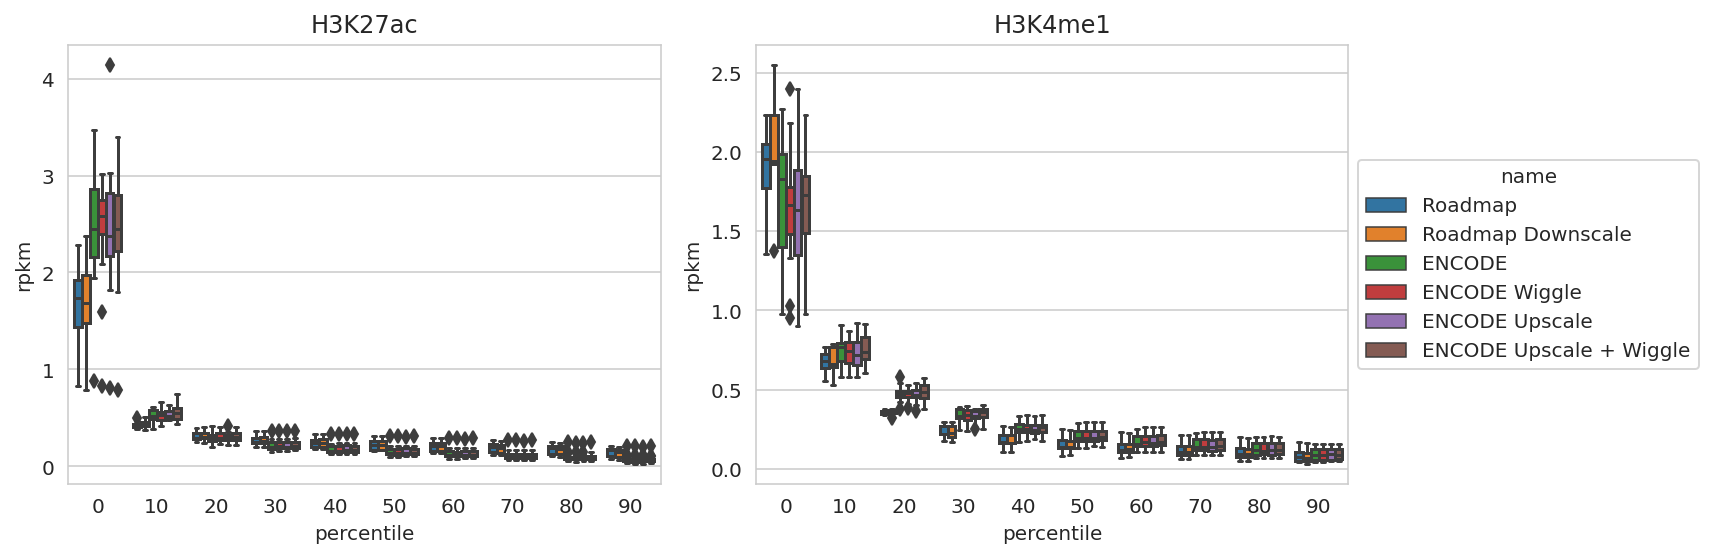

In [280]:
t = df_roughness_perc[df_roughness_perc['cell'] != 'CD34'][
    ['modification', 'cell', 'replicate', 'type', 'name', 'percentile', 'rpkm', 'r']
].groupby(['modification', 'cell', 'replicate', 'type', 'name', 'percentile']).agg('mean').reset_index()
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(
        data=t[(t['modification'] == m)],
        x='percentile', y='rpkm', hue='name',
        # hue_order=['ENCODE', 'ENCODE Upscale 1.5', 'ENCODE Upscale', 'ENCODE Upscale N3', 'ENCODE Upscale + Wiggle', 
        #            'Roadmap', 'Roadmap Downscale'],
        ax=ax)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

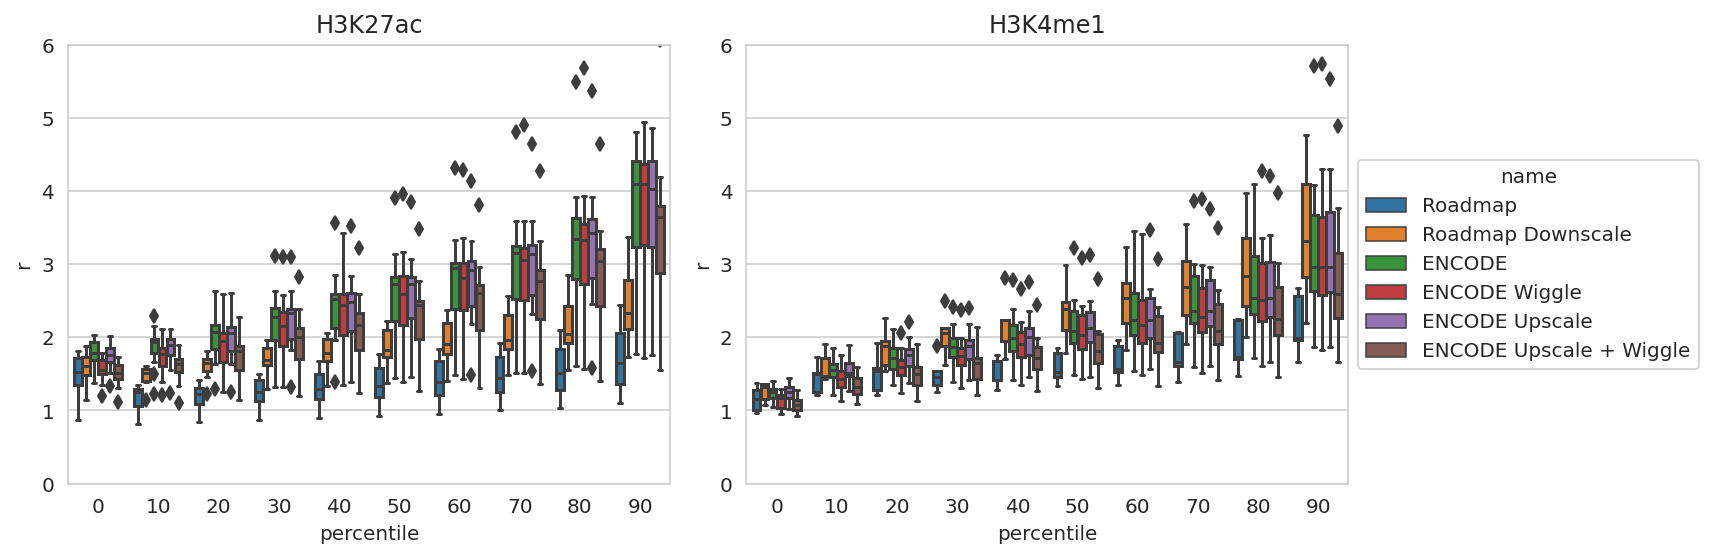

In [281]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(
        data=t[(t['modification'] == m)],
        x='percentile', y='r', hue='name',
        # hue_order=['ENCODE', 'ENCODE Upscale 1.5',  'ENCODE Upscale', 'ENCODE Upscale N3', 'ENCODE Upscale + Wiggle', 
        #            'Roadmap', 'Roadmap Downscale'],
        ax=ax)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim(0, 6)

plt.tight_layout()
plt.show()

H3K27ac ENCODE Upscale


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac ENCODE Upscale + Wiggle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac ENCODE Wiggle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac ENCODE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac Roadmap
H3K27ac Roadmap Downscale


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 ENCODE Upscale
H3K4me1 ENCODE Upscale + Wiggle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 ENCODE Wiggle


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 ENCODE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 Roadmap
H3K4me1 Roadmap Downscale


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


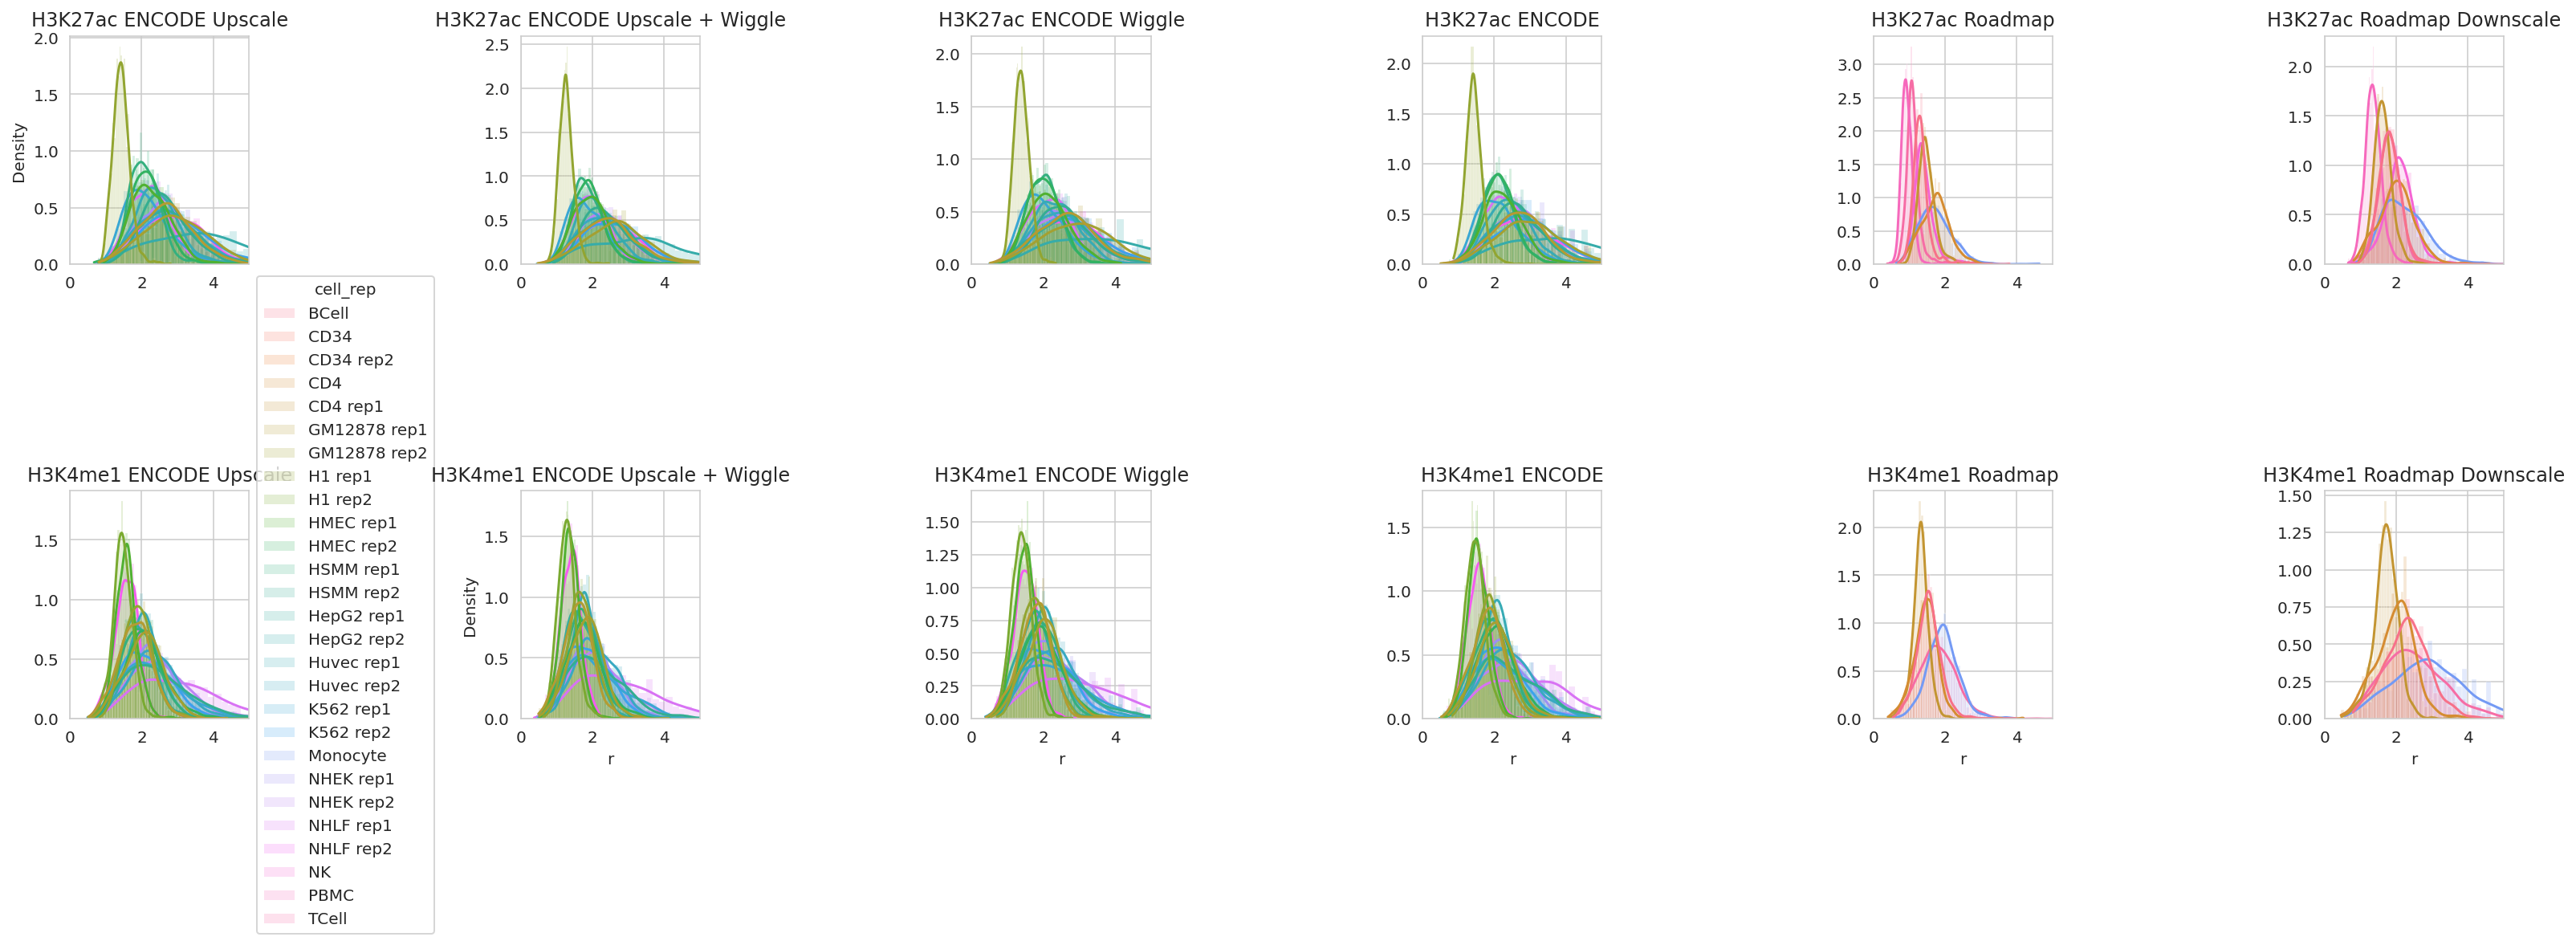

In [282]:
df_roughness['cell_rep'] = df_roughness['cell'] + ' ' + df_roughness['replicate']

plt.figure(figsize=(22, 8))
CELLS = list(wiggle_mix_peaks['cell'].unique())
NAMES = len(df_roughness['name'].unique())
axs = [plt.subplot(2, NAMES, i + 1) for i in range(2 * NAMES)]

for i, (m, name) in enumerate(product(['H3K27ac', 'H3K4me1'], df_roughness['name'].unique())):
    print(m, name)
    ax = axs[i]
    t = df_roughness[
        (df_roughness['cell'] != 'CD34') &
        (df_roughness['modification']==m) & 
        (df_roughness['name']==name)]
    g_results = sns.histplot(data=t,
                             x='r', hue='cell_rep',
                             hue_order=list(sorted(df_roughness['cell_rep'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=50, kde=True, alpha=0.2
                             )
    if (i + 1) == 7:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i % 7 != 0:
        ax.set_ylabel(None)
    if i < 7:
        # ax.set_xticks([], minor=False)
        # g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {name}')
    ax.set_xlim(0, 5)
plt.tight_layout()
plt.show()

## Peaks per percentiles - analyze number of overlapping peaks by coverage / roughness

In [283]:
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()
rows = []
peaks = {tool: [] for tool in TOOLS}
for (m, c, r, ty, perc), group in tqdm(df_roughness_perc.groupby(['modification', 'cell', 'replicate', 'type', 'percentile'])):
    print(m, c, r, ty, perc)
    t = pd.DataFrame([re.split('[\\:\\-]', pos) for pos in group['position']], 
                     columns=['chr', 'start', 'end'])
    t.to_csv(tf, sep='\t', index=False, header=None)
    tf = sorted_file(tf)
    for tool in TOOLS:
        t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                          (wiggle_mix_original_all_peaks['cell'] == c) &
                                          (wiggle_mix_original_all_peaks['replicate'] == r) &
                                          (wiggle_mix_original_all_peaks['type'] == ty) &
                                          (wiggle_mix_original_all_peaks['tool'] == tool)]
        if len(t) == 0:
            print('Ignore', m, c, r, ty, perc)
            continue        
        tool_file = sorted_file(t['file'].values[0])
        perc_peaks, perc_len = lines(tf), bedl(tf).sum()
        tool_peaks, tool_len = lines(tool_file), bedl(tool_file).sum()
        !bedtools intersect -a {tf} -b {tool_file} -wa -u > {tf2}
        overlap1 = lines(tf2)
        !bedtools intersect -b {tf} -a {tool_file} -wa -u > {tf2}
        overlap2 = lines(tf2)
        !bedtools intersect -a {tf} -b {tool_file} -wo > {tf2}
        overlap_len = int(last_col(tf2).sum())
        rows.append((m, c, r, ty, perc, tool, perc_peaks, perc_len, tool_peaks, tool_len, overlap1, overlap2, overlap_len))

df_perc_peaks = pd.DataFrame(rows, columns=[
    'modification', 'cell', 'replicate', 'type', 'percentile', 'tool',
    'perc_peaks', 'perc_len', 'tool_peaks', 'tool_len', 'overlap1', 'overlap2', 'overlap_len'
])
del rows
add_names(df_perc_peaks)
df_perc_peaks.sample(5)

  0%|          | 0/1680 [00:00<?, ?it/s]

H3K27ac BCell  Roadmap 0
H3K27ac BCell  Roadmap 10
H3K27ac BCell  Roadmap 20
H3K27ac BCell  Roadmap 30
H3K27ac BCell  Roadmap 40
H3K27ac BCell  Roadmap 50
H3K27ac BCell  Roadmap 60
H3K27ac BCell  Roadmap 70
H3K27ac BCell  Roadmap 80
H3K27ac BCell  Roadmap 90
H3K27ac BCell  Roadmap_10M 0
H3K27ac BCell  Roadmap_10M 10
H3K27ac BCell  Roadmap_10M 20
H3K27ac BCell  Roadmap_10M 30
H3K27ac BCell  Roadmap_10M 40
H3K27ac BCell  Roadmap_10M 50
H3K27ac BCell  Roadmap_10M 60
H3K27ac BCell  Roadmap_10M 70
H3K27ac BCell  Roadmap_10M 80
H3K27ac BCell  Roadmap_10M 90
H3K27ac CD34  Roadmap 0
H3K27ac CD34  Roadmap 10
H3K27ac CD34  Roadmap 20
H3K27ac CD34  Roadmap 30
H3K27ac CD34  Roadmap 40
H3K27ac CD34  Roadmap 50
H3K27ac CD34  Roadmap 60
H3K27ac CD34  Roadmap 70
H3K27ac CD34  Roadmap 80
H3K27ac CD34  Roadmap 90
H3K27ac CD34  Roadmap_10M 0
H3K27ac CD34  Roadmap_10M 10
H3K27ac CD34  Roadmap_10M 20
H3K27ac CD34  Roadmap_10M 30
H3K27ac CD34  Roadmap_10M 40
H3K27ac CD34  Roadmap_10M 50
H3K27ac CD34  Roadma

modification     cell replicate          type  percentile   tool  \
5188      H3K4me1    Huvec      rep1  w80_20_N2000          70  MACS2   
5931      H3K4me1     NHEK      rep1        x2_N10          20  SICER   
2567      H3K27ac     NHEK      rep1        x2_N10          10  SICER   
4400      H3K4me1     HMEC      rep1        x2_N10           0  MACS2   
3792      H3K4me1  GM12878      rep1        x2_N10          80  MACS2   

      perc_peaks  perc_len  tool_peaks   tool_len  overlap1  overlap2  \
5188         100   1000000       80577   49353066         0         0   
5931         100   1000000       90839  256427561        99       122   
2567         100   1000000       48314  155627486        97       114   
4400         100   1000000        8363    3456338        35        45   
3792         100   1000000       42531   22838086         0         0   

      overlap_len            name  
5188            0   ENCODE Wiggle  
5931       233298  ENCODE Upscale  
2567       216510  ENCODE Upscale  
4400        18970  ENCODE Upscale  
3792            0  ENCODE Upscale

In [284]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
rfile = f'{WD}/perc_peaks_{BIN}bp_{NBINS}_{now}.csv.gz'
print(rfile)
df_perc_peaks.to_csv(rfile, compression='gzip', index=None)

/home/jetbrains/data/2023_wiggle/perc_peaks_10000bp_50000_2024-02-26T17:17.csv.gz


MACS2


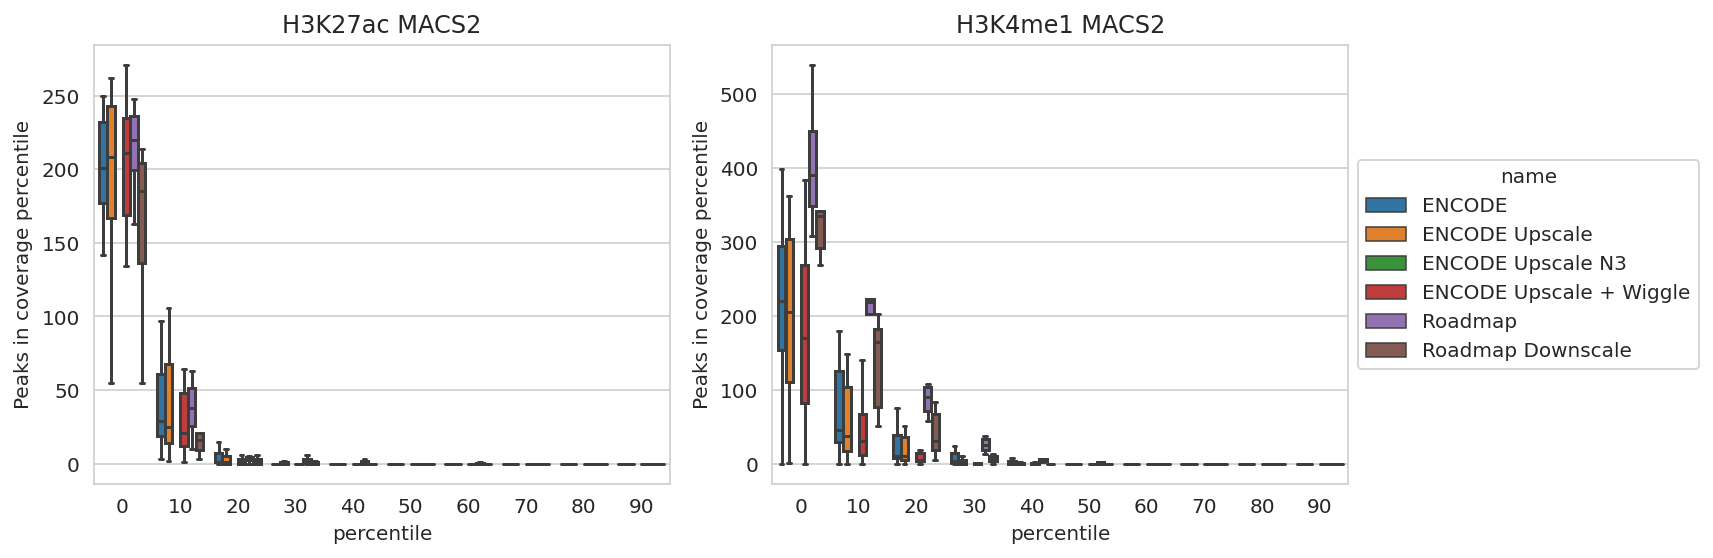

MACS2 broad


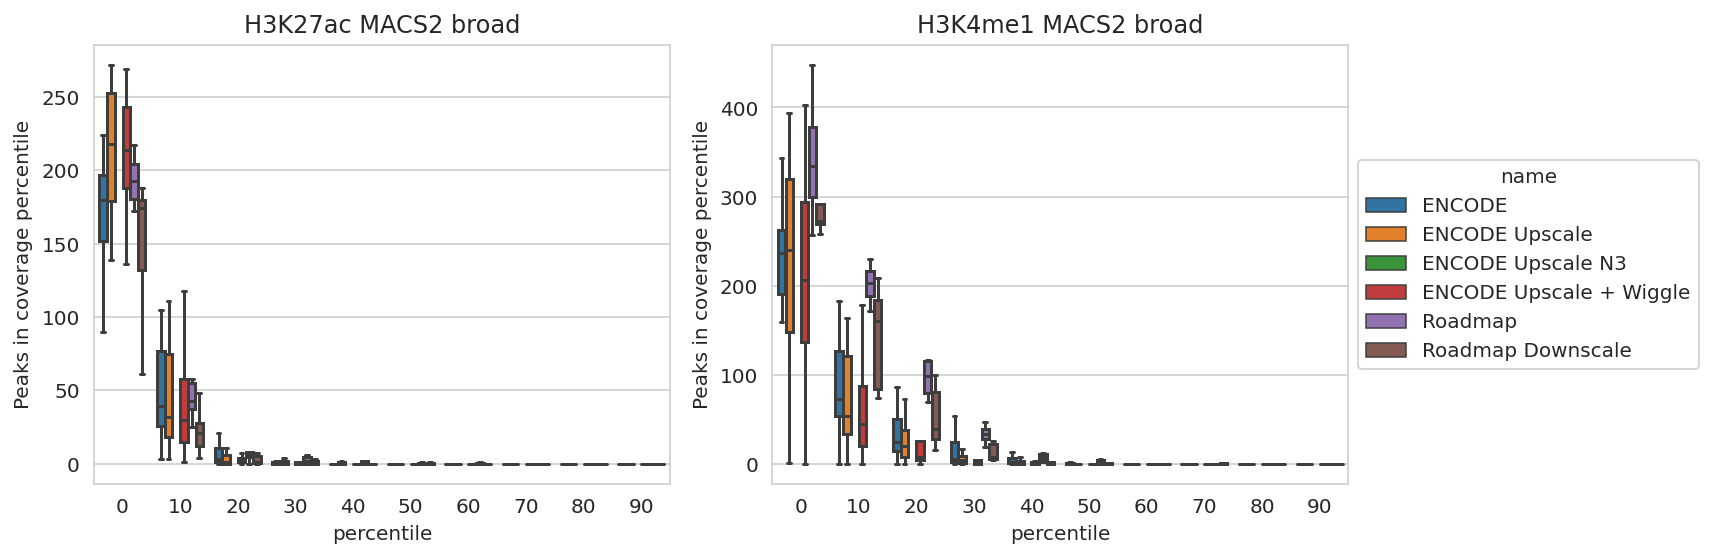

SPAN


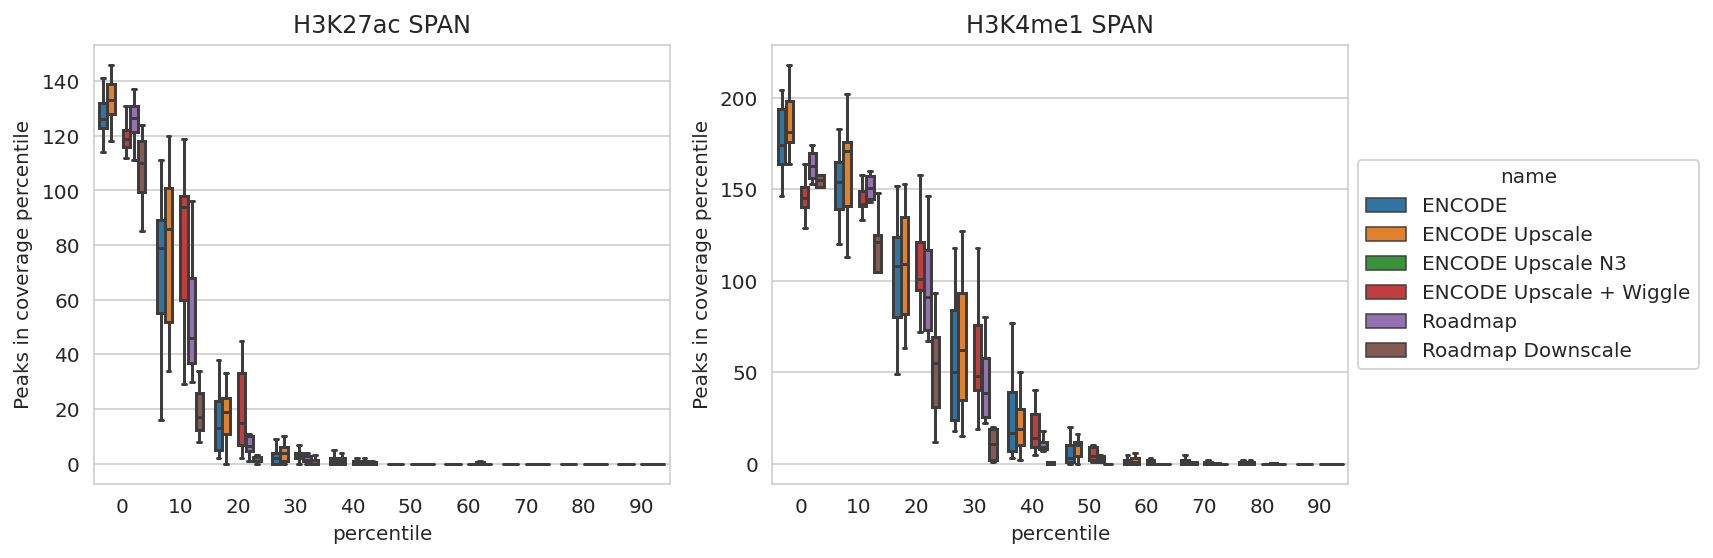

SICER


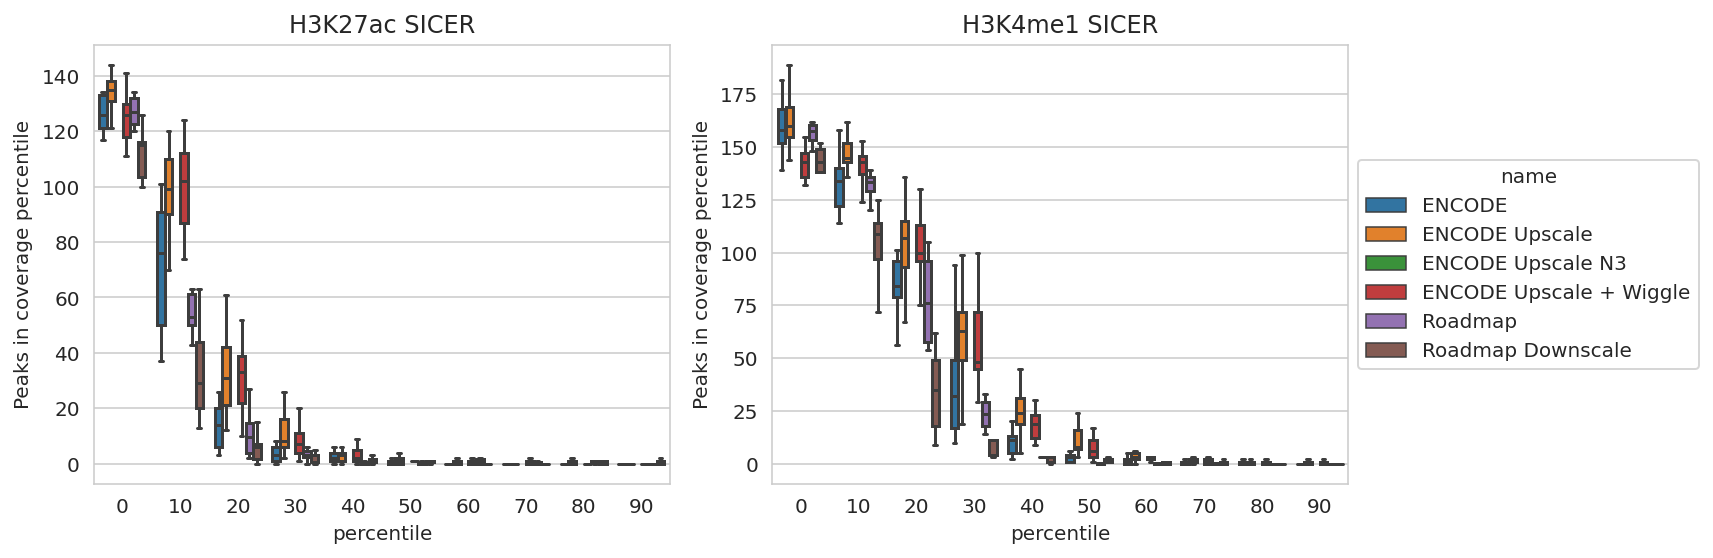

In [285]:
df_perc_peaks['perc_avg_bins'] = df_perc_peaks['perc_len']  / df_perc_peaks['perc_peaks'] / BIN
df_perc_peaks['peaks_per_perc'] = (df_perc_peaks['overlap2'] / df_perc_peaks['tool_peaks']) / df_perc_peaks['perc_avg_bins']

for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(12, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        g_results = sns.boxplot(
            data=df_perc_peaks[(df_perc_peaks['cell'] != 'CD34') & 
                               (df_perc_peaks['modification'] == m) & 
                               (df_perc_peaks['tool'] == tool)],
            x='percentile', y='overlap2', hue='name',
            hue_order=['ENCODE', 'ENCODE Upscale', 'ENCODE Upscale N3', 'ENCODE Upscale + Wiggle', 'Roadmap', 'Roadmap Downscale'],
            ax=ax, showfliers=False)
        # ax.set(yscale='log')
        ax.title.set_text(f'{m} {tool}')
        ax.set_ylabel('Peaks in coverage percentile')
        if i == 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

MACS2


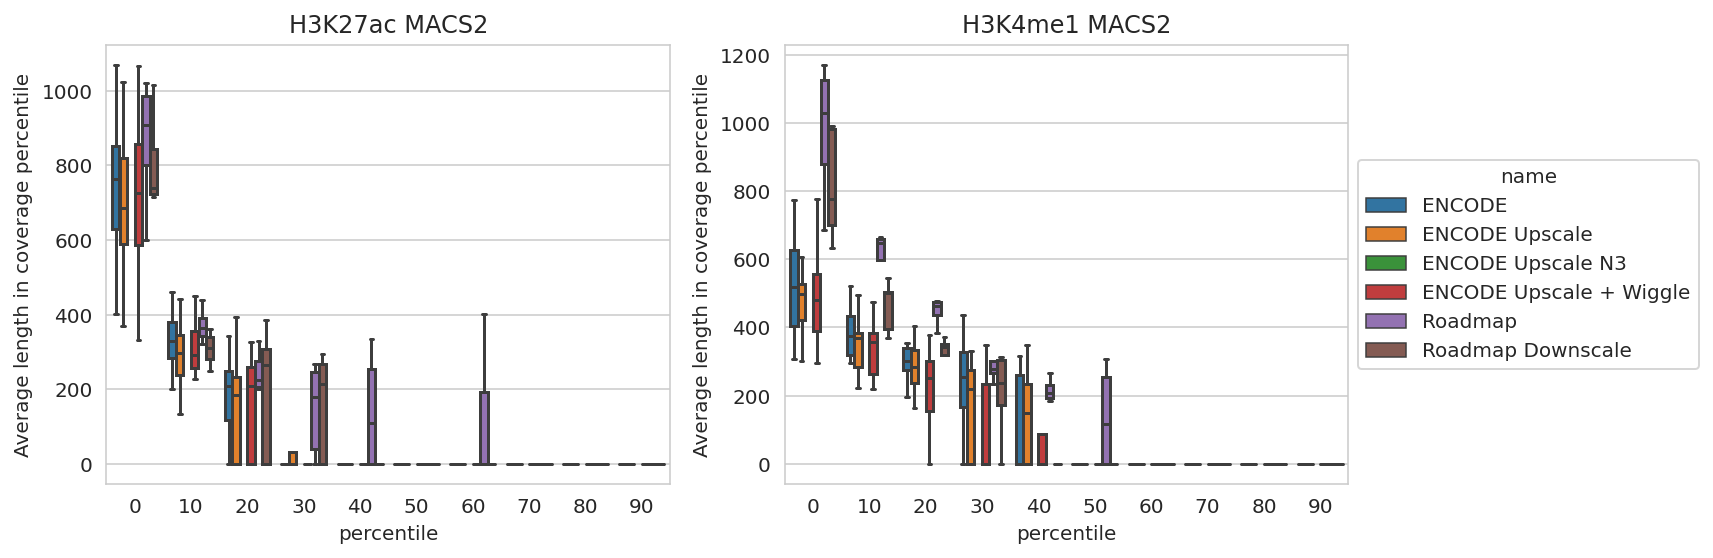

MACS2 broad


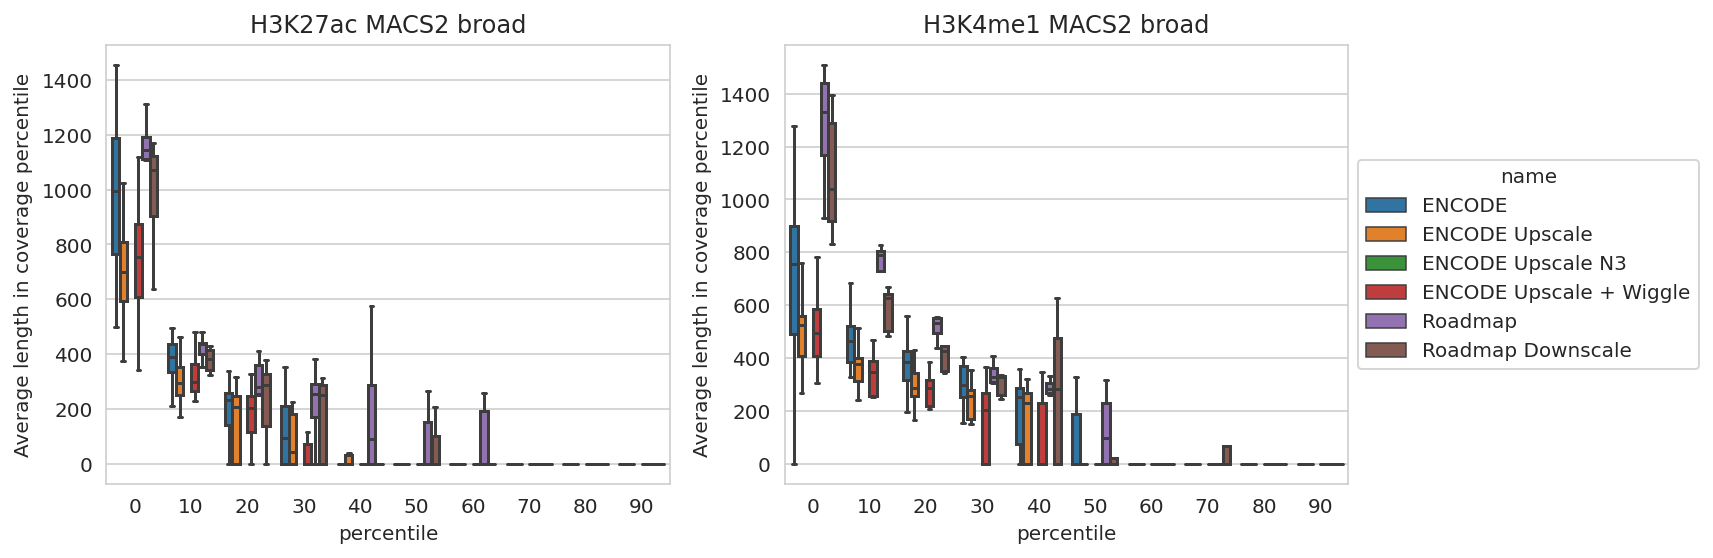

SPAN


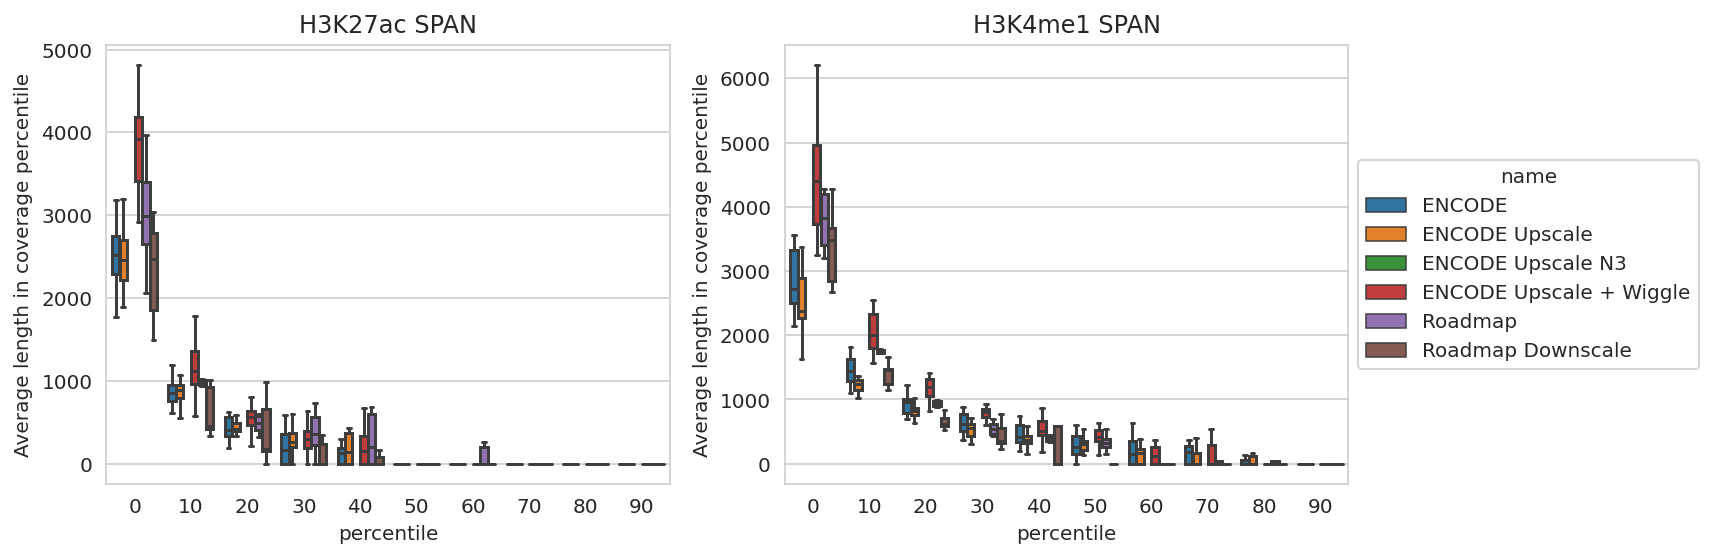

SICER


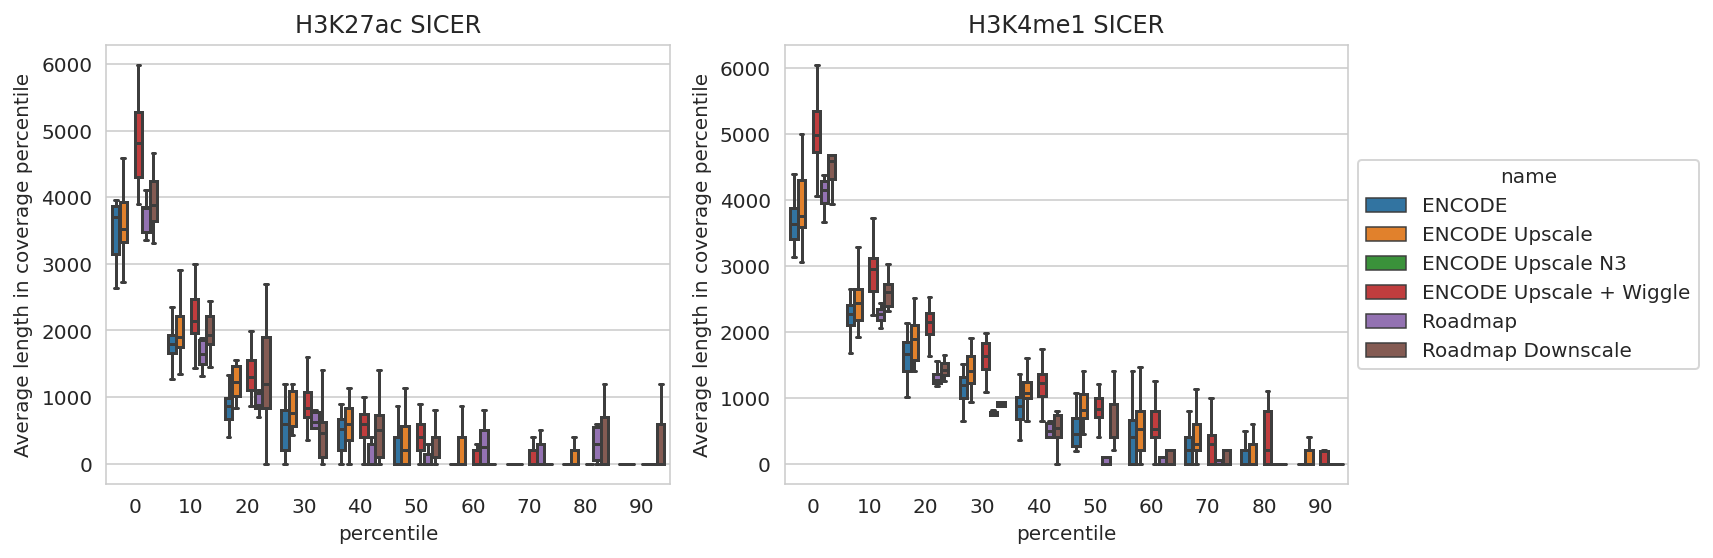

In [286]:
df_perc_peaks['perc_avg_peak_len'] = [d(l, p) for l, p in zip(df_perc_peaks['overlap_len'], df_perc_peaks['overlap2'])]

for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(12, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        g_results = sns.boxplot(
            data=df_perc_peaks[(df_perc_peaks['cell'] != 'CD34') & 
                               (df_perc_peaks['modification'] == m) &
                               (df_perc_peaks['tool'] == tool)],
            x='percentile', y='perc_avg_peak_len', hue='name',
            hue_order=['ENCODE', 'ENCODE Upscale', 'ENCODE Upscale N3', 'ENCODE Upscale + Wiggle', 'Roadmap', 'Roadmap Downscale'],
            ax=ax, showfliers=False)
        # ax.set(yscale='log')
        ax.title.set_text(f'{m} {tool}')
        ax.set_ylabel('Average length in coverage percentile')
        if i == 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

# Aggregate roughness by sample

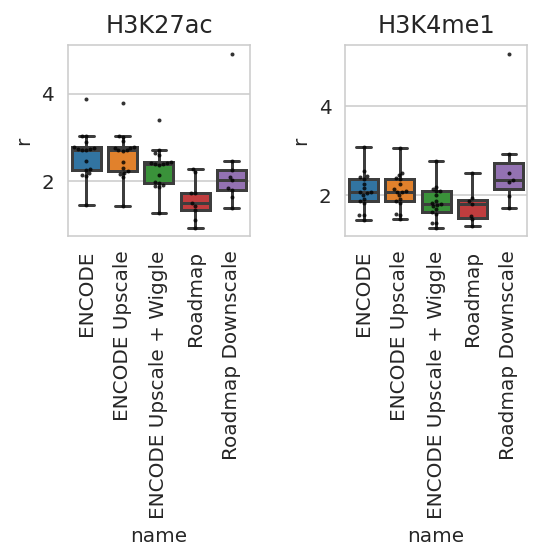

In [287]:
t = df_roughness_perc[
    ['modification', 'cell', 'replicate', 'type', 'name', 'r']
].groupby(['modification', 'cell', 'replicate', 'type', 'name']).agg('mean').reset_index()
plt.figure(figsize=(4, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    sns.boxplot(data=t[(t['modification'] == m)], x='name', y='r',
                order=['ENCODE', 'ENCODE Upscale', 'ENCODE Upscale + Wiggle', 'Roadmap', 'Roadmap Downscale'],
                showfliers=False,
                ax=ax)
    sns.swarmplot(data=t[(t['modification'] == m)], x='name', y='r',
                  dodge=True, size=2, color="black", alpha=0.8,
                  order=['ENCODE', 'ENCODE Upscale', 'ENCODE Upscale + Wiggle', 'Roadmap', 'Roadmap Downscale'],
                  ax=ax)

    ax.title.set_text(m)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [288]:
# df_roughness_aggr = df_roughness[df_roughness['percentile'].isin([0, 10, 20, 30, 40])][
df_roughness_aggr = df_roughness_perc[df_roughness_perc['cell'] != 'CD34'][
    ['modification', 'cell', 'replicate', 'type', 'name', 'ra', 'rq', 'r']
].groupby(['modification', 'cell', 'replicate', 'type', 'name']).agg('mean').reset_index()

df_roughness_aggr['coverage'] = [total_coverages[(m, c, r, ty)] for _, (m, c, r, ty) in 
                                 df_roughness_aggr[['modification', 'cell', 'replicate', 'type']].iterrows()]
df_roughness_aggr.sample(3)

modification  cell replicate                 type  \
149      H3K4me1  NHEK      rep2  x2_N10_w80_20_N2000   
146      H3K4me1  NHEK      rep2               ENCODE   
5        H3K27ac   CD4      rep1          Roadmap_10M   

                        name        ra          rq         r      coverage  
149  ENCODE Upscale + Wiggle  92.81160  131.617463  2.186513  1.840911e+07  
146                   ENCODE  49.20305   71.575061  2.545436  9.428946e+06  
5          Roadmap Downscale  46.19384   60.906616  1.642818  9.337285e+06

## Additional annotation by bw coverage

In [289]:
# t = df_wiggle_bams.copy()
# t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
# # t['scale'] = t['upscale']
# 
# t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
# t2['type'] = t2['dataset']
# t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
# t2['wiggle'] = 0.0
# 
# t3 = df_immune_10m_bams.copy()
# t3['type'] = 'Roadmap_10M'
# t3['scale'] = 2.2
# t3['wiggle'] = 0.0
# 
# all_bams_df = pd.concat([t, t2, t3]).reset_index(drop=True)
# all_bams_df

In [290]:
# reads = []
peaks = {tool: [] for tool in TOOLS}
for _, (m, c, r, ty) in df_roughness_aggr[['modification', 'cell', 'replicate', 'type']].iterrows():
    # t = all_bams_df[(all_bams_df['modification'] == m) & 
    #                 (all_bams_df['cell'] == c) & 
    #                 (all_bams_df['replicate'] == r) & 
    #                 (all_bams_df['type'] == ty)]
    # if len(t) == 0:
    #     reads.append(None)
    # else:
    #     reads.append(t['reads'].values[0])
    for tool in TOOLS:
        t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                          (wiggle_mix_original_all_peaks['cell'] == c) &
                                          (wiggle_mix_original_all_peaks['replicate'] == r) &
                                          (wiggle_mix_original_all_peaks['type'] == ty) &
                                          (wiggle_mix_original_all_peaks['tool'] == tool)]
        if len(t) == 0:
            peaks[tool].append(None)
        else:
            peaks[tool].append(t['peaks'].values[0])
        

# df_roughness_aggr['reads'] = reads
for tool in TOOLS:
    df_roughness_aggr[tool] = peaks[tool]

df_roughness_aggr.sample(5)

modification     cell replicate                 type  \
42       H3K27ac    Huvec      rep1               ENCODE   
96       H3K4me1       H1      rep1               ENCODE   
107      H3K4me1     HMEC      rep1  x2_N10_w80_20_N2000   
15       H3K27ac       H1      rep1         w80_20_N2000   
13       H3K27ac  GM12878      rep2  x2_N10_w80_20_N2000   

                        name         ra          rq         r      coverage  \
42                    ENCODE   59.67030   89.170546  2.457415  1.205919e+07   
96                    ENCODE   35.07409   47.097198  1.927402  7.157681e+06   
107  ENCODE Upscale + Wiggle  108.89121  144.164423  1.375743  2.882424e+07   
15             ENCODE Wiggle   47.47764   61.212191  1.392761  1.223117e+07   
13   ENCODE Upscale + Wiggle   58.13145   86.274146  2.707320  1.204277e+07   

       MACS2  MACS2 broad     SPAN    SICER  
42   50367.0      45003.0  42934.0  38747.0  
96   29669.0      48462.0  60697.0  51468.0  
107   3610.0       5311.0  76486.0  74680.0  
15   13107.0      14775.0  37391.0  31215.0  
13   42993.0      44487.0  30755.0  35640.0

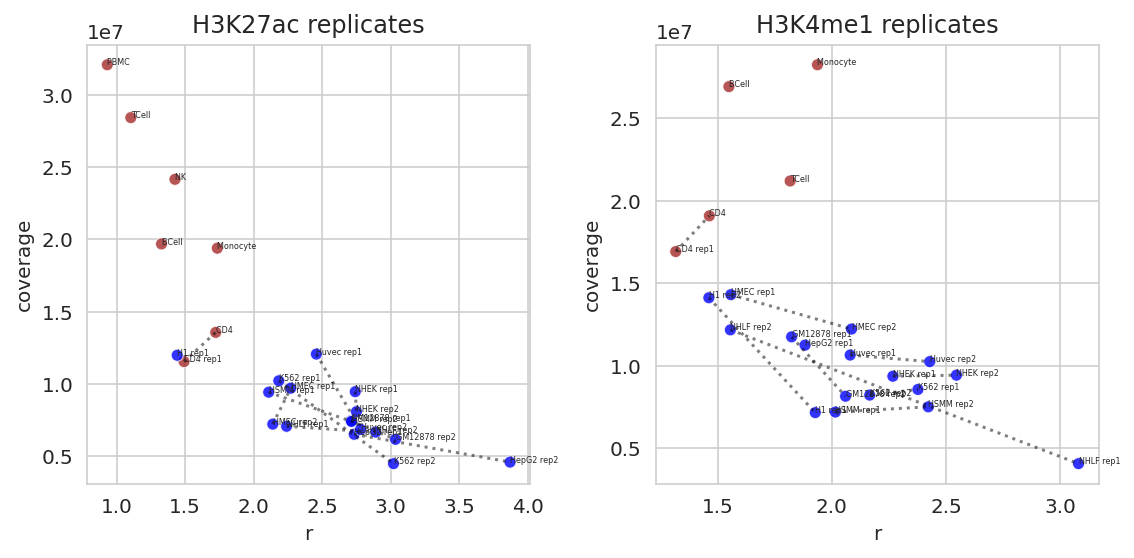

In [291]:
df = df_roughness_aggr
X='r'
Y='coverage'

plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[(df['modification'] == m) & (df['type'].isin(['Roadmap', 'ENCODE']))].copy()
    colors = ['blue' if ty == 'ENCODE' else 'brown' for ty in t['type']]
    sns.scatterplot(data=t,
                    x=X, y=Y,
                    color=colors,
                    alpha=0.8,
                    ax=ax)
    for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
        ax.text(x, y, f'{cell} {rep}', fontsize = 4)
    for _, (cell, ty) in t[['cell', 'type']].drop_duplicates().iterrows():
        tr = t[(t['cell'] == cell) & (t['type'] == ty)]
        reps = list(tr['replicate'].unique())
        if len(tr) > 1:
            for j in range(len(reps)):
                tj = tr[tr['replicate'] == reps[j]]
                for k in range(j + 1, len(reps)):
                    tk = tr[tr['replicate'] == reps[k]]
                    sns.lineplot(x=[tj[X].values[0], tk[X].values[0]],
                                 y=[tj[Y].values[0], tk[Y].values[0]], color='black', ax=ax, alpha=0.5, linestyle='dotted')

    ax.title.set_text(f'{m} replicates')

plt.tight_layout()
plt.show()

## Visualization

In [292]:
def plot_wiggle_dataset(df, X, Y, big, texts, 
                        textcenter=True, colorcol=None, x0line=False, y0line=False,
                        links={'red': [('Roadmap', 'Roadmap_10M')],
                               'green':[('ENCODE', 'x2_N10')],
                               'darkgreen':[('ENCODE', 'x2_N3')],
                               'blue': [('ENCODE', 'w80_20_N5000'), ('x2_N10', 'x2_N10_w80_20_N2000'), ('ENCODE', 'w100_100_N2000')]}, 
                        figsizex=11, figsizey=4,
                        margin=0):
    sns.set_style("white")
    plt.figure(figsize=(figsizex, figsizey))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        t['size'] = [2 if ty in big else 1 for ty in t['name']]

        for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows():
            for color, color_links in links.items():
                for (s, e) in color_links:
                    p1 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == s)]
                    p2 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == e)]
                    if len(p1) == 0 or len(p2) == 0:
                        continue
                    p1x = p1[X].values[0]
                    p1y = p1[Y].values[0]
                    p2x = p2[X].values[0]
                    p2y = p2[Y].values[0]
                    sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color=color, ax=ax, alpha=0.5, linestyle='dotted')
        
        if colorcol is None:
            sns.scatterplot(data=t,
                            x=X, y=Y, hue='name', ax=ax, size='size',
                            hue_order=sorted(df['name'].unique()), alpha=0.8)
        else:
            sns.scatterplot(data=t,
                            x=X, y=Y, hue=colorcol, palette='Blues', ax=ax, size='size')

        for x, y, cell, replicate, ty in zip(t[X], t[Y], t['cell'], t['replicate'], t['name']):
            if ty in texts and (textcenter or (math.fabs(x) > 1e-3 or math.fabs(y) > 1e-3)):
                ax.text(x, y, f'{cell} {replicate}', fontsize = 5)
                
        if x0line:
            sns.lineplot(x=[0, 0], y=[t[Y].min(), t[Y].max()], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        if y0line:
            sns.lineplot(x=[t[X].min(), t[X].max()], y=[0, 0], color='black', ax=ax, alpha=0.5, linestyle='dotted')

        ax.title.set_text(m)
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            # Hide name and size
            ax.legend(handles=handles[1:-(1+len(t['size'].unique()))], labels=labels[1:-(1+len(t['size'].unique()))])
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
        if margin > 0:
            ax.set_xlim(t[X].min() - (t[X].max() - t[X].min()) * margin, t[X].max() + (t[X].max() - t[X].min()) * margin)
            ax.set_ylim(t[Y].min() - (t[Y].max() - t[Y].min()) * margin, t[Y].max() + (t[Y].max() - t[Y].min()) * margin)

    plt.tight_layout()
    plt.show()
    sns.set_style("whitegrid")

Modification scheme


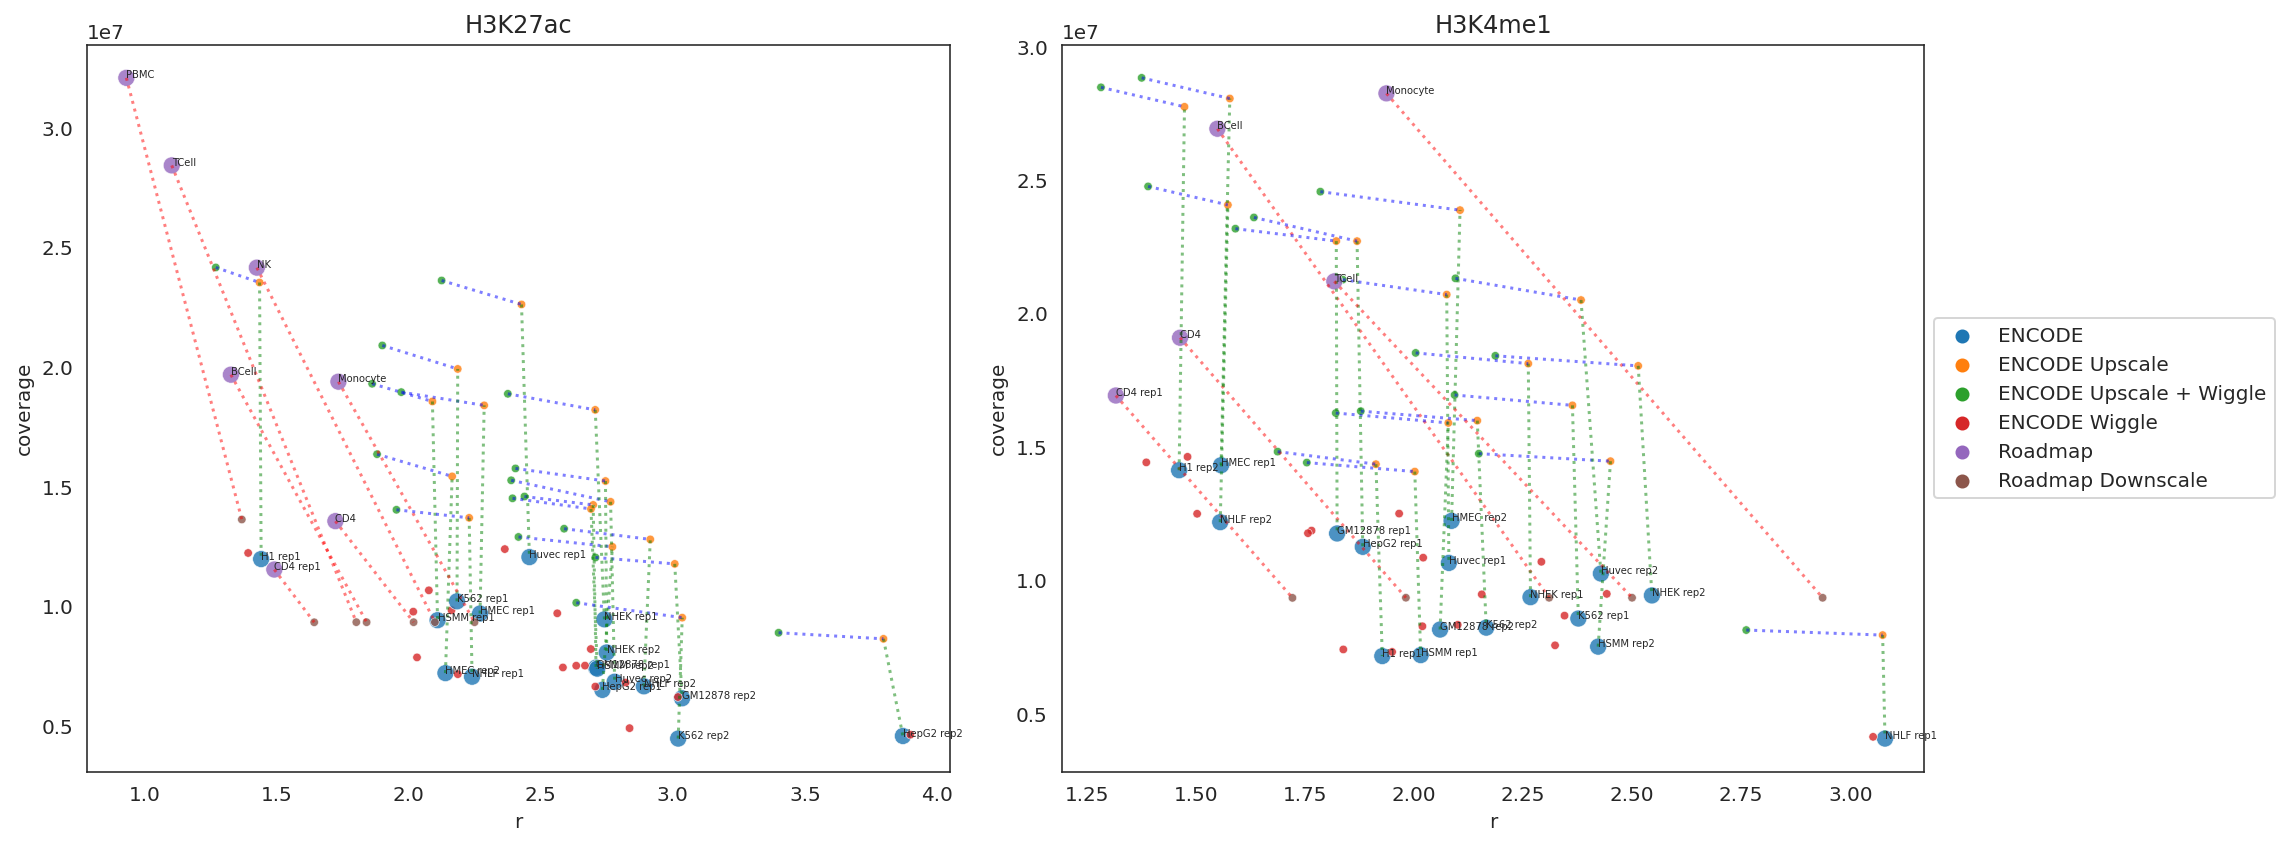

In [293]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']

plot_wiggle_dataset(df_roughness_aggr, X, Y, big, texts, True, figsizex=16, figsizey=6)


Modification scheme


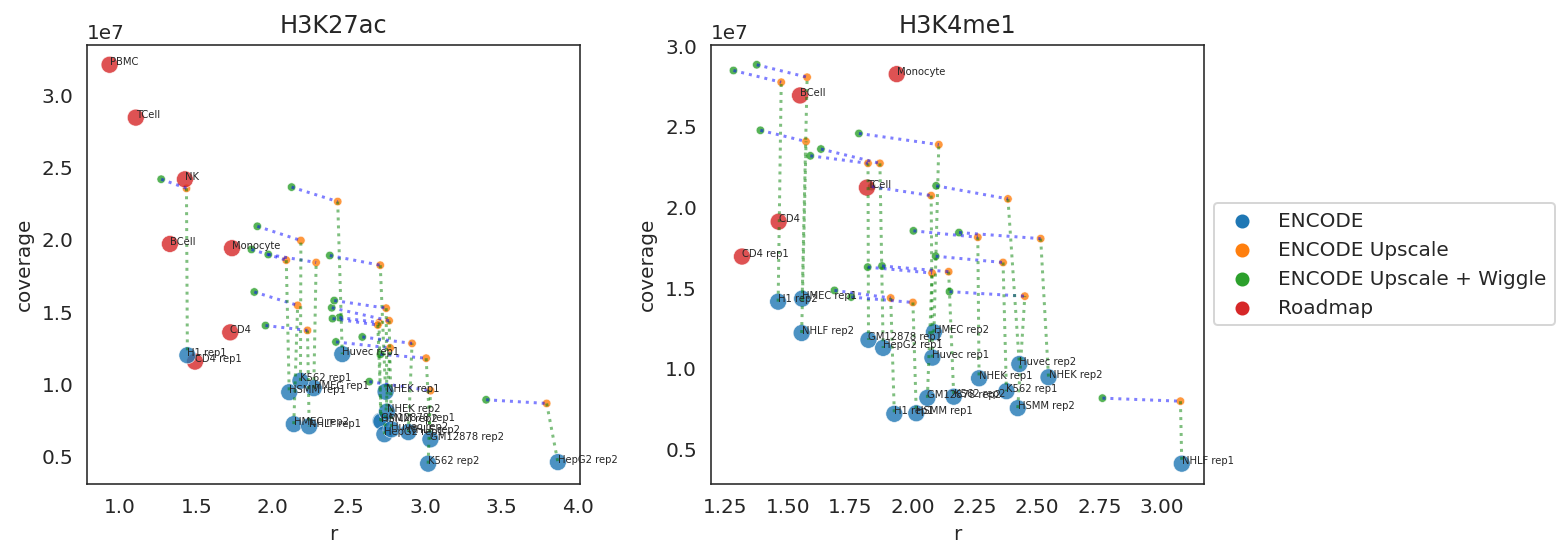

In [294]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']
t = df_roughness_aggr[df_roughness_aggr['type'].isin(['Roadmap', 'ENCODE', 'x2_N10', 'x2_N10_w80_20_N2000'])].copy()
plot_wiggle_dataset(t, X, Y, big, texts, True)

In [295]:
# Find samples with roughness higher than in Roadmap
SAMPLES = {}
for m in ['H3K27ac', 'H3K4me1']:
    SAMPLES[m] = []
    roadmap_threshold = df_roughness_aggr[
        (df_roughness_aggr['modification'] == m) & 
        (df_roughness_aggr['type'] == 'Roadmap') & 
        (df_roughness_aggr['coverage'] > 1e7)]['r'].max()
    print(m, roadmap_threshold)
    t = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                          (df_roughness_aggr['type'] == 'ENCODE') &
                          (df_roughness_aggr['r'] > roadmap_threshold)].copy()
    t.sort_values(by=['r'], ascending=False, inplace=True)
    for _, (c, r) in t[['cell', 'replicate']].iterrows():
        # Skip outliers by coverage / r
        if (m == 'H3K27ac' and (c == 'HepG2' and r == 'rep2' or c == 'K562' and r == 'rep2' ) or 
            m == 'H3K4me1' and (c == 'NHLF' and r == 'rep1' or c == 'HSMM' and r == 'rep2' )
        ): 
            continue
        SAMPLES[m].append((c, r))

H3K27AC_SAMPLES = SAMPLES['H3K27ac']
H3K4ME1_SAMPLES = SAMPLES['H3K4me1'] 

H3K27ac 1.7344915724873684
H3K4me1 1.936890298729534


Modification scheme


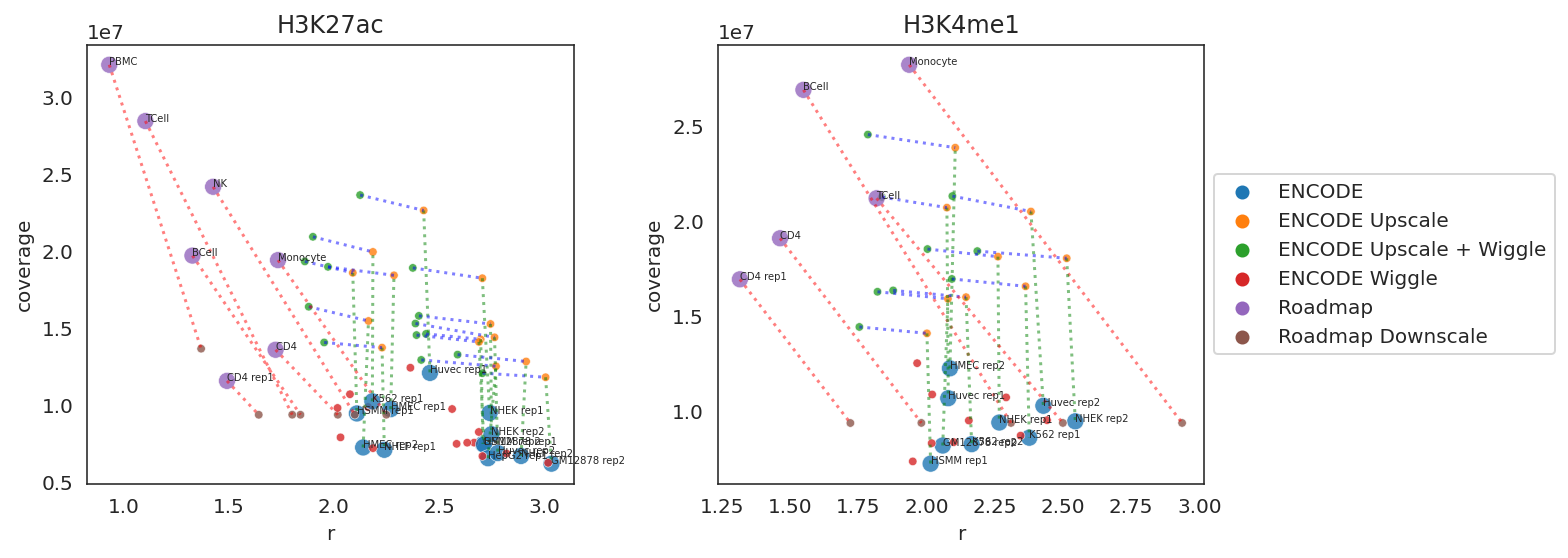

In [296]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
t = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
    (((df_roughness_aggr['modification'] == 'H3K27ac') & 
      ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
     ((df_roughness_aggr['modification'] == 'H3K4me1') & 
      ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()
# big = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']
plot_wiggle_dataset(t, X, Y, big, texts, True)


x2_N10_w80_20_N2000
H3K27ac


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K4me1


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


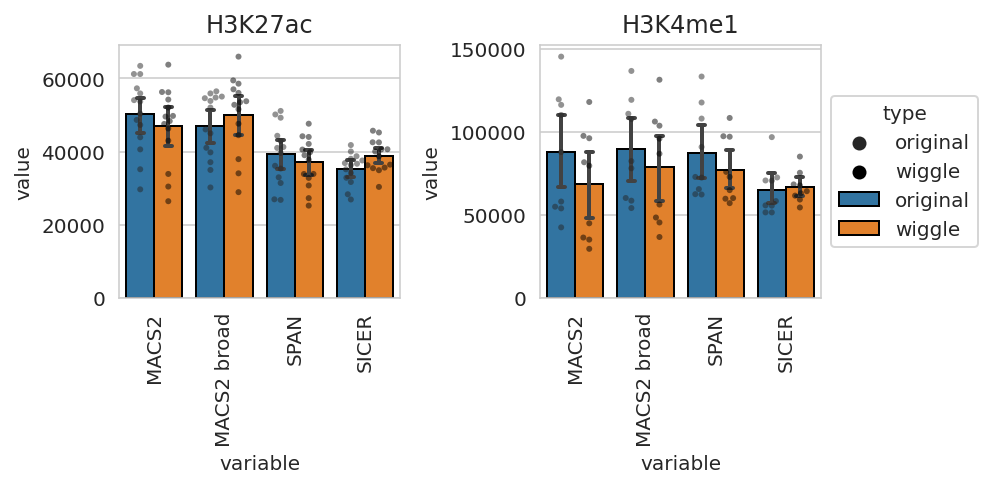

In [297]:
# df = df_roughness_aggr
df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()
# for ty in ['w80_20_N5000', 'x2_N10', 'x2_N10_w80_20_N2000', 'w100_100_N2000']:
for ty in ['x2_N10_w80_20_N2000']:
    print(ty)

    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) &
               (df['type'].isin(['ENCODE', ty]))].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate', 'type'], value_vars=TOOLS).copy()
        t.loc[t['type'] == 'ENCODE', 'type'] = 'original'
        t.loc[t['type'] == ty, 'type'] = 'wiggle'
    
        sns.barplot(data=t, x='variable', y='value', hue='type',
                    capsize=.1, errwidth=2, edgecolor="black",
                    hue_order=['original', 'wiggle'],
                    # order=['MACS2', 'MACS2 broad', 'SICER'],
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],                            
                    ax=ax,
                    )
        sns.swarmplot(data=t, x='variable', y='value', hue='type',
                      dodge=True, size=3, color="black", alpha=0.5,
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                      ax=ax)
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

Modification scheme


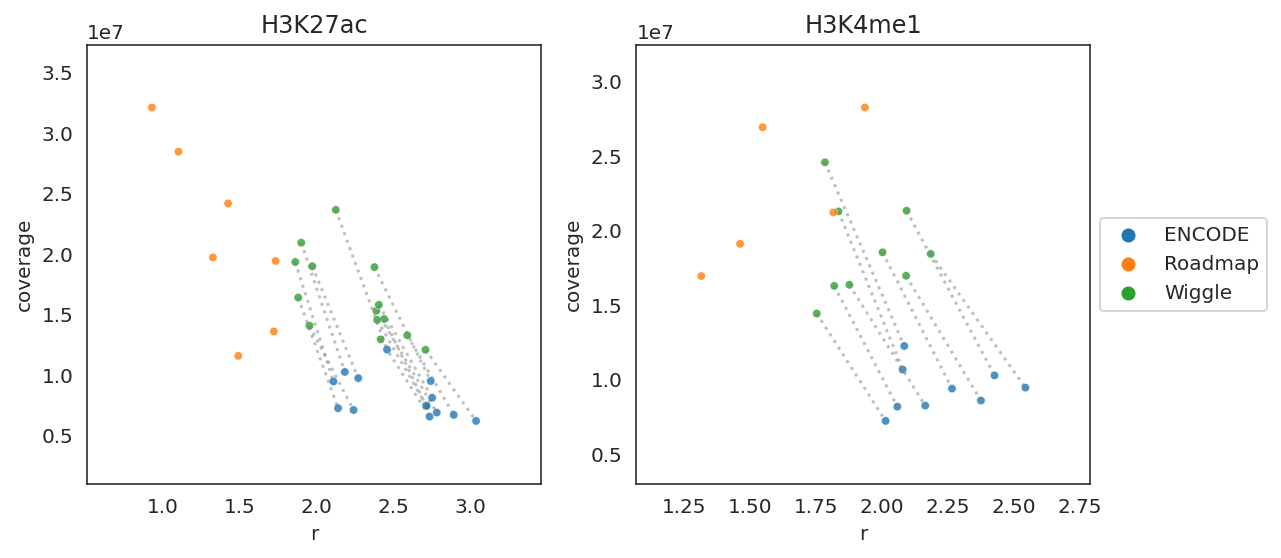

In [298]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
t = df_roughness_aggr[(df_roughness_aggr['name'] == 'Roadmap') |
                      (df_roughness_aggr['name'].isin(['ENCODE', 'ENCODE Upscale + Wiggle'])) &
                      (((df_roughness_aggr['modification'] == 'H3K27ac') &
                        ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                       ((df_roughness_aggr['modification'] == 'H3K4me1') &
                        ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()
texts = []
t.loc[df['name'] == 'ENCODE Upscale + Wiggle', 'name'] = 'Wiggle'
big = ['ENCODE', 'Roadmap', 'Wiggle']
t = t[~((t['type'] == 'Roadmap') & (t['coverage']< 1e7))]
plot_wiggle_dataset(t, X, Y, big, [], True, links={'grey':[('ENCODE', 'x2_N10_w80_20_N2000')]}, figsizex=9, figsizey=4, margin=0.2)

All cells roughness


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


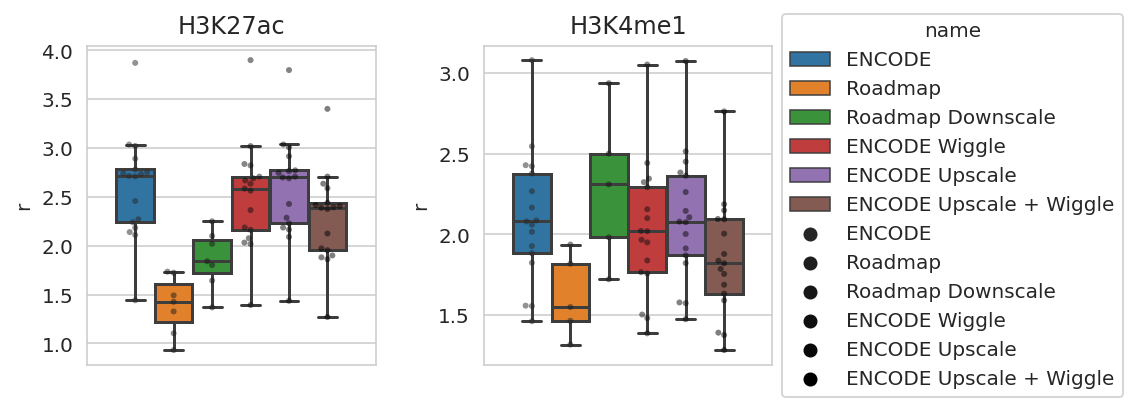

In [299]:
print('All cells roughness')
df = df_roughness_aggr
# df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
#                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
#                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
#                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
#                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[df['modification'] == m].copy()
    sns.boxplot(data=t, x='modification', y='r', hue='name',
                hue_order=['ENCODE', 'Roadmap', 'Roadmap Downscale', 
                           'ENCODE Wiggle', 'ENCODE Upscale', 
                           'ENCODE Upscale + Wiggle'],
                # hue_order=['ENCODE', 'Upscale & Wiggle', 'Roadmap'],
                showfliers=False,
                ax=ax)
    sns.swarmplot(data=t, x='modification', y='r', hue='name',
                  dodge=True, size=3, color="black", alpha=0.5,
                  hue_order=['ENCODE', 'Roadmap', 'Roadmap Downscale',
                             'ENCODE Wiggle', 'ENCODE Upscale',
                             'ENCODE Upscale + Wiggle'],
                  ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


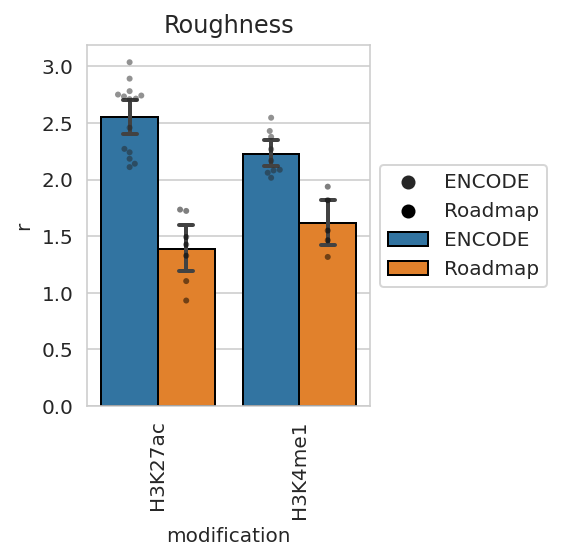

In [300]:
# df = df_roughness_aggr.copy()
df = df_roughness_aggr[(df_roughness_aggr['name'] == 'Roadmap') |
                       (df_roughness_aggr['name'] == 'ENCODE') &
                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()

df.loc[df['name'] == 'ENCODE Upscale + Wiggle', 'name'] = 'Wiggle'
plt.figure(figsize=(4, 4))
ax = plt.axes()
sns.barplot(data=df, hue='name', x='modification', y='r', 
            order=['H3K27ac', 'H3K4me1'],
            hue_order=['ENCODE', 'Roadmap'],
            capsize=.1, errwidth=2, edgecolor="black",
            ax=ax
            )
sns.swarmplot(data=df, hue='name', x='modification', y='r',
              dodge=True, size=3, color="black", alpha=0.5,
              order=['H3K27ac', 'H3K4me1'],
              hue_order=['ENCODE', 'Roadmap'],
              ax=ax)

ax.set_title('Roughness')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [301]:
# print('Modification scheme')
# 
# X = 'avlength'
# Y = 'peaks'
# t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['name'].str.contains('Roadmap')) |
#                                   (((wiggle_mix_original_all_peaks['modification'] == 'H3K27ac') &
#                                     ([(c, r) in H3K27AC_SAMPLES for c, r in zip(wiggle_mix_original_all_peaks['cell'], wiggle_mix_original_all_peaks['replicate'])])) |
#                                    ((wiggle_mix_original_all_peaks['modification'] == 'H3K4me1') &
#                                     ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(wiggle_mix_original_all_peaks['cell'], wiggle_mix_original_all_peaks['replicate'])])))].copy()
# for tool in TOOLS:
#     print(tool)
#     # big = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
#     big = ['Roadmap', 'ENCODE']
#     texts = ['Roadmap', 'ENCODE']
#     plot_wiggle_dataset(t[t['tool'] == tool], X, Y, big, texts, True)

## Roughness vs peak calling

In [302]:
# for Y in TOOLS:
#     print(Y)
#     X = 'r'
#     big = ['ENCODE', 'Roadmap']
#     texts = ['Roadmap', 'ENCODE']
#     plot_wiggle_dataset(df_roughness_aggr, 'r', Y, big, texts, True)

In [303]:
from scipy.stats import spearmanr
for name in ['ENCODE Upscale', 'ENCODE Upscale', 'ENCODE Upscale + Wiggle']:
    for tool, m in product(TOOLS, ['H3K27ac', 'H3K4me1']):
        print(tool, m)
        t = df_roughness_aggr[(df_roughness_aggr['modification'] == m) & (df_roughness_aggr['name'] == name)]
        for y in ['coverage', 'r']:
            corr, pval = spearmanr(t[tool], t[y])
            print(f'{name} {m} {tool} vs {y} corr={corr:.2e} p={pval:.2e}')    

MACS2 H3K27ac
ENCODE Upscale H3K27ac MACS2 vs coverage corr=1.91e-01 p=4.62e-01
ENCODE Upscale H3K27ac MACS2 vs r corr=-6.13e-02 p=8.15e-01
MACS2 H3K4me1
ENCODE Upscale H3K4me1 MACS2 vs coverage corr=-1.08e-01 p=6.80e-01
ENCODE Upscale H3K4me1 MACS2 vs r corr=4.78e-01 p=5.23e-02
MACS2 broad H3K27ac
ENCODE Upscale H3K27ac MACS2 broad vs coverage corr=1.99e-01 p=4.45e-01
ENCODE Upscale H3K27ac MACS2 broad vs r corr=-5.64e-02 p=8.30e-01
MACS2 broad H3K4me1
ENCODE Upscale H3K4me1 MACS2 broad vs coverage corr=-9.56e-02 p=7.15e-01
ENCODE Upscale H3K4me1 MACS2 broad vs r corr=4.73e-01 p=5.51e-02
SPAN H3K27ac
ENCODE Upscale H3K27ac SPAN vs coverage corr=4.22e-01 p=9.19e-02
ENCODE Upscale H3K27ac SPAN vs r corr=-3.77e-01 p=1.35e-01
SPAN H3K4me1
ENCODE Upscale H3K4me1 SPAN vs coverage corr=5.66e-01 p=1.78e-02
ENCODE Upscale H3K4me1 SPAN vs r corr=-1.72e-01 p=5.10e-01
SICER H3K27ac
ENCODE Upscale H3K27ac SICER vs coverage corr=6.45e-01 p=5.21e-03
ENCODE Upscale H3K27ac SICER vs r corr=-7.65e-01 p

# Center by previous / original point

In [304]:
rows = []
for _, row in tqdm(df_roughness_aggr.iterrows()):
    m, c, r, ty, name = row['modification'], row['cell'], row['replicate'], row['type'], row['name']
    if ty == 'ENCODE' or ty == 'Roadmap':
        rows.append([m, c, r, ty, name] + [row[t] for t in TOOLS + ['r', 'coverage']] + 
                    [0] * (len(TOOLS) + 2) * 4 + 
                    [row[t] for t in TOOLS + ['r', 'coverage']] * 2)
        continue
    original = 'Roadmap' if ty == 'Roadmap_10M' else 'ENCODE'
    previous = 'Roadmap' if ty == 'Roadmap_10M' else ('x2_N10' if ty == 'x2_N10_w80_20_N2000' else 'ENCODE')
    t_original = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                                   (df_roughness_aggr['cell'] == c) &
                                   (df_roughness_aggr['replicate'] == r) &
                                   (df_roughness_aggr['type'] == original)]
    t_previous = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                                   (df_roughness_aggr['cell'] == c) &
                                   (df_roughness_aggr['replicate'] == r) &
                                   (df_roughness_aggr['type'] == previous)]    
    if len(t_original) == 0 or len(t_previous) == 0:
        continue
    
    data = [m, c, r, ty, name]
    data.extend([row[col] for col in TOOLS + ['r', 'coverage']])
    data.extend([row[col] - t_original[col].values[0] for col in TOOLS + ['r', 'coverage']])
    data.extend([int(100 * d(row[col] - t_original[col].values[0], t_original[col].values[0])) for col in TOOLS + ['r', 'coverage']])
    data.extend([row[col] - t_previous[col].values[0] for col in TOOLS + ['r', 'coverage']])
    data.extend([int(100 * d(row[col] - t_previous[col].values[0], t_previous[col].values[0])) for col in TOOLS + ['r', 'coverage']])
    data.extend([t_original[tl].values[0] for tl in TOOLS + ['r', 'coverage']])
    data.extend([t_previous[tl].values[0] for tl in TOOLS + ['r', 'coverage']])
    rows.append(data)
df_roughness_aggr_z = pd.DataFrame(rows, 
                                   columns=['modification', 'cell', 'replicate', 'type', 'name'] + TOOLS + ['r', 'coverage'] +
                                           [f'diff vs original {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'diff% vs original {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'diff vs previous {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'diff% vs previous {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'original {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'previous {t}' for t in TOOLS + ['r', 'coverage']])
df_roughness_aggr_z.sample(5)

0it [00:00, ?it/s]

ValueError: cannot convert float NaN to integer

In [ ]:
df = df_roughness_aggr_z[df_roughness_aggr_z['type'] == 'x2_N10_w80_20_N2000']
X = 'diff vs original MACS2 broad'
Y = 'diff vs original SPAN'
plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[df['modification'] == m].copy()
    colors = ['green' if (row['modification'] == 'H3K27ac') & ((row['cell'], row['replicate']) in H3K27AC_SAMPLES) |
                         (row['modification'] == 'H3K4me1') & ((row['cell'], row['replicate']) in H3K4ME1_SAMPLES)
              else 'blue' for _, row in t.iterrows()]
    
    amin = min(t[X].min(), t[Y].min())
    amax = max(t[X].max(), t[Y].max())
    sns.lineplot(x=[amin, amax], y=[0, 0], color='red', ax=ax, alpha=0.5, linestyle='dotted')
    sns.lineplot(x=[0, 0], y=[amin, amax], color='red', ax=ax, alpha=0.5, linestyle='dotted')    
    
    sns.scatterplot(data=t,
                    x=X, y=Y,
                    color=colors,
                    alpha=0.8,
                    ax=ax,
                    )

    for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
        ax.text(x, y, f'{cell} {rep}', fontsize = 4)
    ax.title.set_text(m)

    ax.set_xlim(amin, amax)
    ax.set_ylim(amin, amax)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import spearmanr
for name in ['ENCODE Upscale', 'ENCODE Wiggle', 'ENCODE Upscale + Wiggle', 'Roadmap Downscale']:
    for tool, m in product(TOOLS, ['H3K27ac', 'H3K4me1']):
        print(tool, m)
        t = df_roughness_aggr_z[(df_roughness_aggr_z['modification'] == m) & (df_roughness_aggr_z['name'] == name)]
        dt = f'diff vs original {tool}'
        corr, pval = spearmanr(t[dt], t['original r'])
        print(f'{m} {dt} vs original r corr={corr:.2e} p={pval:.2e}')

        dt = f'diff vs original {tool}'
        ot = f'original {tool}'
        corr, pval = spearmanr(t[dt], t[ot])
        print(f'{name} {m} {dt} vs {ot} corr={corr:.2e} p={pval:.2e}')
 

In [ ]:
# df = df_roughness_aggr_z
df = df_roughness_aggr_z[(df_roughness_aggr_z['name'].str.contains('Roadmap')) |
                         (((df_roughness_aggr_z['modification'] == 'H3K27ac') &
                           ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])) |
                          ((df_roughness_aggr_z['modification'] == 'H3K4me1') &
                           ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])))].copy()

DIFF_TOOLS = [f'diff% vs original {t}' for t in TOOLS]
for name in ['ENCODE Wiggle', 'ENCODE Upscale', 'ENCODE Upscale + Wiggle', 'Roadmap Downscale']:
    print(name)
    plt.figure(figsize=(5, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) & (df['name'] == name)].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate'], value_vars=DIFF_TOOLS)
        for tool in TOOLS:
            t.loc[t['variable'] == f'diff% vs original {tool}', 'variable'] = tool
            
        g_results = sns.boxplot(data=t,
                                x='variable', y='value',
                                # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                palette=TOOLS_PALETTE,
                                showfliers=False,
                                ax=ax)
        sns.lineplot(x=[-1, 3], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        ax.set_xlabel('Tool')
        ax.set_ylabel('Difference %')

    plt.tight_layout()
    plt.show()

In [ ]:
# df = df_roughness_aggr_z
df = df_roughness_aggr_z[(df_roughness_aggr_z['name'].str.contains('Roadmap')) |
                       (((df_roughness_aggr_z['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])) |
                        ((df_roughness_aggr_z['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])))].copy()
# 
DIFF_TOOLS = [f'diff% vs previous {t}' for t in TOOLS]
for name in ['ENCODE Upscale', 'ENCODE Wiggle', 'ENCODE Upscale + Wiggle', 'Roadmap Downscale']:
    print(name)
    plt.figure(figsize=(5, 6))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) & (df['name'] == name)].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate'], value_vars=DIFF_TOOLS)
        t2 = df[(df['modification'] == m)].copy()
        g_results = sns.boxplot(data=t,
                                x='variable', y='value',
                                order=DIFF_TOOLS,
                                showfliers=False,
                                ax=ax)
        sns.lineplot(x=[-1, 4], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        ax.set_xlabel('tool')
        ax.set_ylabel('diff')

    plt.tight_layout()
    plt.show()

In [ ]:
df = df_roughness_aggr_z
big =  ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
texts = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
for Y in TOOLS:
    print(Y)
    plot_wiggle_dataset(df, f'original {Y}', f'diff vs original {Y}', big, texts, False, None, y0line=True) 

In [ ]:
df = df_roughness_aggr_z
big =  ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
texts = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
for Y in TOOLS:
    print(Y)
    plot_wiggle_dataset(df, f'original r', f'diff vs original {Y}', big, texts, False, None, y0line=True)

## Estimate jaccard between wiggle replicates

In [ ]:
tf = tempfile.mktemp()
rows = []

for (m, c, t, ty), dft in tqdm(list(wiggle_mix_original_peaks.groupby(['modification', 'cell', 'tool', 'type']))):
    print(m, c, t, ty)
    if len(dft) != 2:
        continue
    file1 = sorted_file(dft['file'].values[0])
    file2 = sorted_file(dft['file'].values[1])
    peaks1 = lines(file1)
    peaks2 = lines(file2)
    len1 = bedl(file1).sum()
    len2 = bedl(file2).sum()
    !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
    overlap1 = lines(tf)
    !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
    overlap2 = lines(tf)
    !bedtools intersect -a {file1} -b {file2} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    rows.append((m, c, t, ty, peaks1, peaks2, len1, len2, overlap1, overlap2, overlap_len))

df_wiggle_reps = pd.DataFrame(rows, columns=['modification', 'cell', 'tool', 'type',
                                             'peaks1', 'peaks2', 'length1', 'length2',
                                             'overlap1', 'overlap2', 'overlap_len'])
del rows
df_wiggle_reps['jaccard'] = df_wiggle_reps['overlap_len'] / (df_wiggle_reps['length1'] + df_wiggle_reps['length2'] - df_wiggle_reps['overlap_len'])
df_wiggle_reps.sample(3)

In [ ]:
t = df_wiggle_reps[df_wiggle_reps['type'].isin(['ENCODE', 'x2_N10_w80_20_N2000'])][['modification', 'cell', 'tool', 'jaccard', 'type']]
t = t.pivot(index=['modification', 'cell', 'tool'], columns='type', values='jaccard').reset_index()
t.rename({'ENCODE': 'Original', 'x2_N10_w80_20_N2000': 'Wiggle'}, axis=1, inplace=True)
t.sample(3)

In [ ]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    tm = t[t['modification'] == m]
    # tm = tm[tm['tool'] != 'SPAN']
    minxy = min(tm['Original'].min(), tm['Wiggle'].min())
    maxxy = max(tm['Original'].max(), tm['Wiggle'].max())
    sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='black', ax=ax, alpha=0.5, linestyle='dotted')
    sns.scatterplot(tm,
                    palette=TOOLS_PALETTE,
                    hue_order=TOOLS,
                    # hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                    x='Original', y='Wiggle', hue='tool', alpha=0.8,
                    ax = ax)
    ax.set_title(m)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# END